## <a id="Top" style="color:black;">Top</a>
- [Reproducing Stefano's calculations](#stef)
-[Plotting BH evaporation](#BHevap)
- [Fitting the Lightcurves of GRB candidates](#lightcurves)
- [Expanding to other sources](#candidates)
- [Fitting GRB spectrum to spectral model](#fitting)

In [14]:
from astropy import units as u
from astropy import constants as c
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, norm

In [15]:
# For threeML lightcurves & fitting.

import warnings
warnings.simplefilter("ignore")

from threeML import *

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

from threeML.io.package_data import get_path_of_data_file

Proposed BH mass = {$10^5, 10^9,10^{12}$} kg

Proposed BH number density = ${(\frac{4}{3} \pi d^3)}^{-1}$ where d = 0.015 pc

BH mass density $\rho_{BH} = M_{BH} {(\frac{4}{3} \pi d^3)}^{-1}$

given homogeneous DM mass density 0.3 GeV / cm3

fraction of DM which is BH = $\frac{\rho_{BH}}{\rho_{DM}}$

and lastly:

Jfactor for galactic center $J_{GC} \sim 10^{19} GeV/cm^2$

### <a id="stef" style="color:black;">Reproducing Stefano's calculations</a>

galactic center BH mass column density $I_{GC} = J_{GC} \frac{\rho_{BH}}{\rho_{DM}} * \frac{1}{M_{BH}} = J_{GC} \frac{1}{\frac{4}{3} \pi d^3}$ *making this equation invariant to the individual mass of the evaporating black hole*

allow nearby BH flux $\phi_{BH} = \frac{\phi_{\gamma}}{4 \pi d^2}$ noting that $\phi_{\gamma}$ represents initial BH flux

by which $\phi_{\gamma} = 4 \pi d^2 \phi_{BH}$

and the galactic center flux $\phi_{GC} = \phi_{\gamma} \frac{J_{GC}}{\frac{4}{3} \pi d^3} = 4 \pi d^2 \phi_{BH} \frac{J_{GC}}{\frac{4}{3} \pi d^3}$

which, again, the signal from the nearby BH is $\phi_{BH} = \frac{\phi_{\gamma}}{4 \pi d^2}$ such that we want the ratio of signals 

$\frac{\phi_{GC}}{\phi_{BH}} = 4 \pi d^2 \frac{J_{GC}}{\frac{4}{3} \pi d^3}$ cancelling out the individual BH flux

Note: I keep the d's separate as they are composed of different units when calculated numerically below

In [16]:
# I go through the steps of introducing M_bh and cancelling it out.
# The function at the end efficiently skips this step.
M_bh = 10**7 * u.kg

rho_bh = M_bh / (4/3* (3.14159) * (0.015 * u.pc)**3)

#fracBH = rho_bh / (0.01 * c.M_sun * u.pc**-3)
fracBH = rho_bh / (0.3 * u.GeV / (u.cm**3) )

J = 10**19 * u.GeV * u.cm**(-2) 

I_GC = J * fracBH / M_bh

I_GC = I_GC.to('1 / cm2')

print('Signal from galactic center: ',I_GC)

I_bh = 1 / (4* (3.14159) * (0.015 * u.pc)**2)

I_bh = I_bh.to('1 / cm2')

print('Signal from nearby BH : ',I_bh)

print('Flux ratio: %.2f'%(I_GC/I_bh))

print('Req\'d distance for I_GC/I_bh = 1: ',3 * J)

2.3578530003620492e+24 cm / pc3
Signal from galactic center:  8.025370477243687e-32 1 / cm2
Signal from nearby BH :  3.714555864689924e-35 1 / cm2
Flux ratio: 2160.52
Req'd distance for I_GC/I_bh = 1:  3e+19 GeV / cm2


In [4]:
def flux_ratio(J , DM_density, BH_density):
    
    # Unit Check
    J = J.to('GeV / cm2')
    DM_density = DM_density.to('GeV / cm3')
    BH_density = BH_density.to('cm')
    
    I_target = J / (DM_density * 4/3* (3.14159) * BH_density**3)
    I_target = I_target.to('1 / cm2')
    
    I_bh = 1 / (4* (3.14159) * BH_density**2)
    I_bh = I_bh.to('1 / cm2')
    
    return I_target/I_bh

print('again, we find flux ratio to be %.2f'%flux_ratio(10**19 * u.GeV / u.cm**2, 0.3 * u.GeV / u.cm**3, (0.015 * u.pc) ))

again, we find flux ratio to be 2160.52


### More precision with measured values

Precision can be improved for values of the assumed homogeneous DM density and the GC J factor.

$\rho_{DM}$: [Determination of the local dark matter density in our Galaxy](https://www.aanda.org/articles/aa/pdf/2010/01/aa13381-09.pdf)

$J_{GC}$: [Jeltema, Profumo](https://arxiv.org/abs/1408.1699)

In [5]:
DM_density = [0.2, 0.4] * u.GeV / u.cm**3

unit = 10**18 * u.GeV / u.cm**2
J_factors = {
    'BUR_PN': 3.91, 'BUR_MOS': 3.77,
    'NFW_PN': 12.5, 'NFW_MOS': 12.2,
    'EIN_PN': 14.9, 'EIN_MOS': 14.4
}

def test_limits(density):
    for k,v in J_factors.items():
        print('%s %.2f'%(k,flux_ratio(v*unit, density, 0.015*u.pc )))
        
print('Lower bound DM density:')
test_limits(DM_density[0])

print('\nUpper bound:')
test_limits(DM_density[1])

Lower bound DM density:
BUR_PN 1267.14
BUR_MOS 1221.77
NFW_PN 4050.97
NFW_MOS 3953.75
EIN_PN 4828.76
EIN_MOS 4666.72

Upper bound:
BUR_PN 633.57
BUR_MOS 610.89
NFW_PN 2025.49
NFW_MOS 1976.88
EIN_PN 2414.38
EIN_MOS 2333.36


$M = M_{10} \times 10^{10}g \to \frac{dM}{dM_{10}} = 10^{10}g$

$\frac{dM_{10}}{dt} = -5.34 \times 10^{-5} f(M) M_{10}^{-2} s^{-1}$ where f(M) = 0.06 * 2

$\frac{dM_{10}}{dt}\frac{dM}{dM_{10}} = \frac{dM}{dt} = 10^{10}g \times (-5.34 \times 10^{-5}) f(M) M_{10}^{-2} s^{-1}$

$\approx -5.34 \times 10^4 g/s M_{10}^{-2}$

In [6]:
ddt_M = 10**10 * u.g * -5.34 * 10**-5 * (0.06 * 2) / u.s # * M_10^-2

print('%2e %s M_10^-2'%(ddt_M.value, ddt_M.unit))

-6.408000e+04 g / s M_10^-2


$E_\gamma = T \approx 1.06 TeV * M_{10}^{-1}$

$E_\gamma \times |\frac{dM}{dt}| = \phi_\gamma \approx 1.06 TeV \times 5.34 \times 10^4 g/s M_{10}^{-3}$

In [7]:
TeV = 5*10**20 *u.g

flux = 1.06 * TeV * np.abs(ddt_M) # * M_10^-3

print('%2e %s M_10^-3'%(flux.value, flux.unit))

3.396240e+25 g2 / s M_10^-3


<!-- recall from above $\frac{\phi_{GC}}{\phi_{BH}} = 4 \pi d^2 \frac{J_{GC}}{\frac{4}{3} \pi d^3}$ which we defined as flux_ratio() -->

from $\phi_\gamma$, allow $M_{10}^{-3} = (\frac{10^{10}g}{M_{EBH}})^3$

such that $\phi_\gamma \approx 3.3 \times 10^{25} \frac{10^{30}g^3}{M_{EBH}^3}$

for meaningful detection, $\frac{|\phi_\gamma|}{4\pi d^2} < 10^{-15} cm^{-2}s^{-1}$ where RHS is telescope resolution

which can be solved for $d < (\frac{4 \pi 10^{-15} cm^{-2} s^{-1}}{|\phi_\gamma|})^\frac{1}{2}$

In [8]:
flux_M = lambda M: flux * 10**30 * u.g**3 / M**(3)

func_Md = lambda M,d: flux_M(M) / (4* 3.14159 * d**2)

func_M = lambda M: np.sqrt(4 * 3.14159 * 10**(-15) * u.cm**-2 * u.s**-1 / flux_M(M))

# for example, for d=20cm, M=10**7kg
print(func_Md(M = 10**7 * u.kg, d = 20 * u.cm).to('g2 / cm2 s'))

6.756610506144978e+21 g2 / (cm2 s)


In the following figure, we plot the above equation for d(M), for distance vs. BH mass.

Any black holes in the domain BELOW the blue line are discoverable by a telescope of resolution >$10^{-15} cm^{-2}s^{-1}$

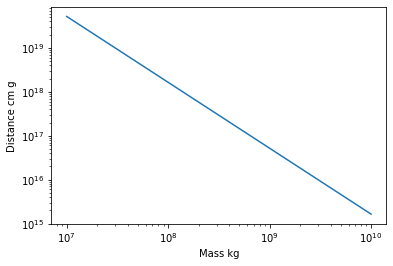

In [11]:
M = np.linspace(10**7, 10**10) * u.kg

F_d = 1/func_M(M).to('1 / (cm g)')

plt.loglog(M, F_d)
plt.xlabel('Mass kg')
plt.ylabel('Distance %s'%F_d.unit)
plt.show()

### <a id="BHevap" style="color:black;">Plotting BH evaporation</a>
[back to top](#Top)

Paper: [BH evaporation models](https://arxiv.org/pdf/1510.04372.pdf)
- 3.3: Photon spectrum
- 3.4: Time-integrated photon spectrum
- 3.5: Light curve

In [50]:
import numpy as np

import scipy.integrate as I

#GBM Energy Spectrum
Emin = 50*10**(-6) # GeV
Emax = 300*10**(-6) # GeV

class photon_spectrum:
    def __init__(self):
        self.A = 6.339 * 10**23 # /GeV/s
        self.B = 1.1367 * 10**24
        self.c1 = 1.13*10**19
        self.c2 = .0962
        self.c3 = 1.908
        self.c4 = 1.982
        self.x_c = 1.287 * 10**(-4)
    def theta_s(self, x):
        return 0.5 * (1+ np.tanh(10*x))
    def fluxdtdE_frag(self, x):
        return ( 
                ( self.A * x**(-3/2) ) * ( 1 - self.theta_s(x - .3) ) + 
                self.B * np.exp(-x) * 1/(x*x + x) * self.theta_s(x - 3)
                )
    def fluxdtdE_direct(self, x):
        c = self.c1 * x**6 / np.expm1(x)

        f = np.exp(-self.c2 
                - self.c4*(np.log(x) - self.c3)*
                (1+np.tanh(20* (np.log(x) - self.c3) ) ))
        f[np.where(f == 2)] = 1.
        return f
    def x(self, E, # Unitless energy /GeV
          tau): # Unitless remaining liftime /s
        return self.x_c * (E) * tau**(1/3)
    def __call__(self, E, tau, both=True, x=None):

        param = self.x(E, tau)  
        if both == 'primary':
            return self.fluxdtdE_direct(param)
        elif both == 'secondary': 
            return self.fluxdtdE_frag(param)
        else: 
            return self.fluxdtdE_frag(param) + self.fluxdtdE_direct(param)
        
def detailed_lightcurve(tau, energy_range, normalization = 1., xoffset=0.):
    p_s = photon_spectrum()
    if len(tau)==1:
        x = p_s.x(energy_range, tau)
        return np.multiply(normalization, I.simps( y=p_s(energy_range, tau) , x=x )), tau + xoffset
    else:
        curve = []
        for i in tau:
            x = p_s.x(energy_range, i)
            curve.append( np.multiply(normalization, I.simps( y=p_s(energy_range, i) , x=x )) ) 
        return np.array(curve) , tau + xoffset

def afterglow(tau, delta, t_m, t_p, normalization):
    # lifetime only, no spectrum.
    # Norm * \frac{e^{(-t -\Delta)/tp } }{1 - e^{(-t - \Delta)/tm} }
    return normalization*np.exp(-(1/t_p)*(tau-delta))/(1 + np.exp(-(1/t_m)*(tau-delta)))

#def lightcurve_at_distance(tau, energy_range = np.linspace(Emin, Emax, 1000), d):

# Simplifying lightcurve with powerlaw of index -.52
def lightcurve(tau, energy_range, normalization = 1., index = .52):
    return normalization*tau**(-index)

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

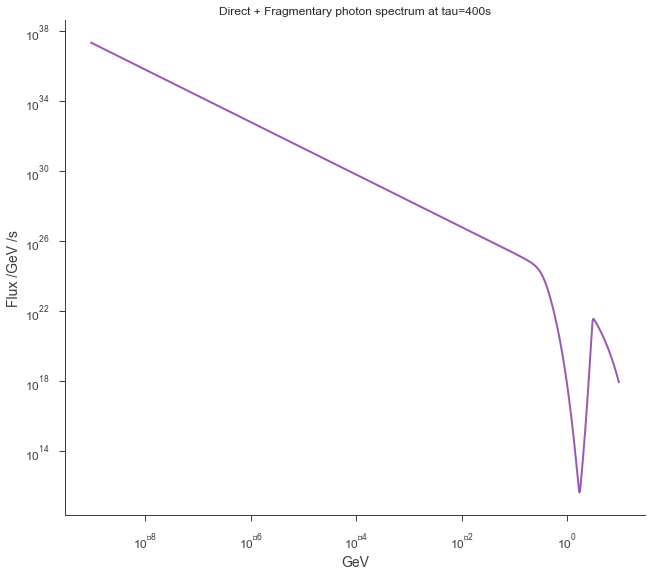

In [17]:
fig, ax = plt.subplots()

p_s = photon_spectrum()
x = p_s.x(np.linspace(10**(-6), 10**4, 1000), 400)

ax.loglog(x, p_s(np.linspace(10**(-6), 10**4, 1000), 400))

ax.set_ylabel('Flux /GeV /s')
ax.set_xlabel('GeV')
ax.set_title('Direct + Fragmentary photon spectrum at tau=400s')
plt.show()

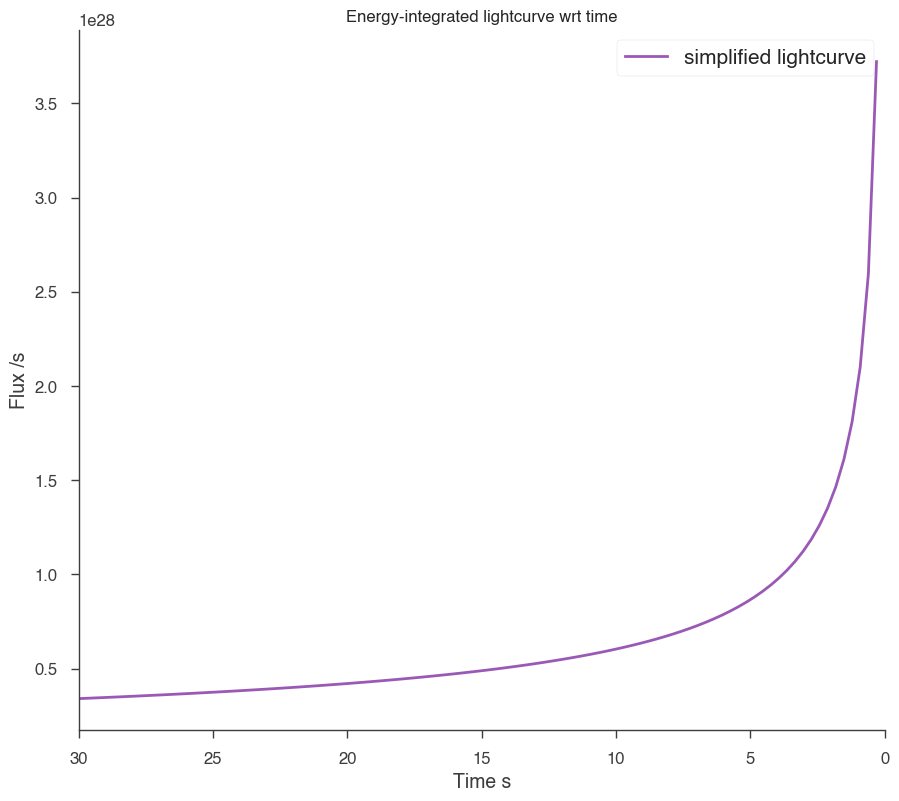

In [13]:
# Here's the fun one: energy-integrated lightcurve in the GBM band for 50s EBH

tau = np.linspace(30,0,100) 
#print(len(tau))

fig, ax = plt.subplots()

curve, t = detailed_lightcurve(tau, energy_range = np.linspace(Emin, Emax, 1000), normalization = 1, xoffset = 0)
#print(t)
#print(curve)

s_curve = lightcurve(tau,energy_range = np.linspace(Emin, Emax, 1000), normalization = 2*1e28)
"""
curve = []
for i in t:
    curve.append(lightcurve(tau = i, energy_range = np.linspace(Emin, Emax, 1000)))
"""
#ax.plot(tau,curve, label = 'detailed lightcurve')
ax.plot(tau, s_curve, label = 'simplified lightcurve')
#ax.plot(tau, s_curve + afterglow(tau, delta=-10, t_m=10, t_p=10, normalization=1e27), label = 'lightcurve + afterglow')
ax.set_xlim(30,0)

ax.set_xlabel("Time s")
ax.set_ylabel("Flux /s")
ax.set_title("Energy-integrated lightcurve wrt time")
ax.legend(prop={'size':15})
plt.show()

### <a id="lightcurves" style="color:black;">Fitting the Lightcurves</a>
[back to top](#Top)

In [16]:
gbm_catalog = FermiGBMBurstCatalog()

In [17]:
def query_catalog(GRBNAME = '150902733', time_in = -30, time_out = 60, dt = .1, gbm_detectors = None):
    gbm_catalog.query_sources('GRB%s'%GRBNAME)

    grb_info = gbm_catalog.get_detector_information()['GRB%s'%GRBNAME]
    
    if gbm_detectors is None:
        gbm_detectors = grb_info["detectors"]
    print(gbm_detectors)
    source_interval = grb_info["source"]["fluence"]
    background_interval = grb_info["background"]["full"]
    dload = download_GBM_trigger_data('bn%s'%GRBNAME, detectors=gbm_detectors)

    fluence_plugins = []
    time_series = {}
    figures = []
    for det in gbm_detectors:

        ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
            det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
        )

        ts_cspec.set_background_interval(*background_interval.split(","))
        ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

        ts_tte = TimeSeriesBuilder.from_gbm_tte(
            det,
            tte_file=dload[det]["tte"],
            rsp_file=dload[det]["rsp"],
            restore_background=f"{det}_bkg.h5",
        )

        time_series[det] = ts_tte

        ts_tte.set_active_time_interval(source_interval)

        figures.append(ts_tte.view_lightcurve(time_in, time_out, dt = dt))
    return figures

import warnings
warnings.filterwarnings('ignore')

def get_curves(fig):
    data = fig.get_axes()[0].get_lines()[0].get_xydata()
    x = data[:,0]
    curve = data[:,1]
    
    bckg_data = fig.get_axes()[0].get_lines()[1].get_xydata()
    bckg_data = bckg_data[:,1]
    
    return x, curve, bckg_data

def show_curves(figures):
    figya, ax = plt.subplots()
    for i,fig in enumerate(figures):
        x,curve, bckg = get_curves(fig)
        ax.plot(x,curve,label="detector %s"%i)
        ax.plot(x[0:-1],bckg, '--',label='bckg %s'%i)
        ax.legend(prop={'size':15})
    return figya

['n0' 'n1' 'n3' 'b0']


20:32:33 INFO      file glg_cspec_n0_bn150902733_v00.pha is already downloaded!           ]8;id=900720;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=613458;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

20:32:34 INFO      file glg_cspec_n0_bn150902733_v02.rsp is already downloaded!           ]8;id=92979;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=940431;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n0_bn150902733_v00.fit is already downloaded!             ]8;id=796453;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=379264;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

20:32:35 INFO      file glg_cspec_n1_bn150902733_v00.pha is already downloaded!           ]8;id=227562;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=898501;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n1_bn150902733_v02.rsp is already downloaded!           ]8;id=618400;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=765389;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n1_bn150902733_v00.fit is already downloaded!             ]8;id=243907;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=2140;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

20:32:36 INFO      file glg_cspec_n3_bn150902733_v00.pha is already downloaded!           ]8;id=936695;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=185286;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n3_bn150902733_v02.rsp is already downloaded!           ]8;id=575784;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=289895;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

20:32:37 INFO      file glg_tte_n3_bn150902733_v00.fit is already downloaded!             ]8;id=938674;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=32336;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b0_bn150902733_v00.pha is already downloaded!           ]8;id=511573;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=287765;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b0_bn150902733_v02.rsp is already downloaded!           ]8;id=944665;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=314963;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

20:32:38 INFO      file glg_tte_b0_bn150902733_v00.fit is already downloaded!             ]8;id=343808;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=196787;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:32:43 INFO      Auto-determined polynomial order: 1                                ]8;id=411704;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=343396;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:33:02 INFO      None 1-order polynomial fit with the mle method                               ]8;id=529955;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=980063;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n0_bkg.h5                                         ]8;id=899263;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=687441;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n0_bkg.h5                                         ]8;id=118577;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=886559;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n0_bkg.h5                              ]8;id=693650;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=459278;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 3.84-17.408 for n0                                    ]8;id=643404;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=802921;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:33:08 INFO      Auto-determined polynomial order: 1                                ]8;id=812001;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=439952;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:33:22 INFO      None 1-order polynomial fit with the mle method                               ]8;id=531255;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=434144;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=887288;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=688027;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=911705;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=689390;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=690316;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=459019;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

20:33:23 INFO      Interval set to 3.84-17.408 for n1                                    ]8;id=682642;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=268989;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:33:27 INFO      Auto-determined polynomial order: 1                                ]8;id=892552;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=738147;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_03 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:33:44 INFO      None 1-order polynomial fit with the mle method                               ]8;id=839502;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=410804;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=445993;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=797569;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=348246;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=971256;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=158688;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=978649;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

20:33:45 INFO      Interval set to 3.84-17.408 for n3                                    ]8;id=393093;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=942906;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:33:50 INFO      Auto-determined polynomial order: 1                                ]8;id=491621;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=972479;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:34:04 INFO      None 1-order polynomial fit with the mle method                               ]8;id=41930;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=586467;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=763198;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=88494;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=840335;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=43244;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

20:34:05 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=70159;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=877528;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 3.84-17.408 for b0                                    ]8;id=984609;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=809465;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Maximum 8693.350706461864 at index 392, time 9.2
Maximum 8321.464903356951 at index 392, time 9.2
Maximum 9368.182837570457 at index 392, time 9.2
Maximum 7508.1787332614285 at index 392, time 9.2


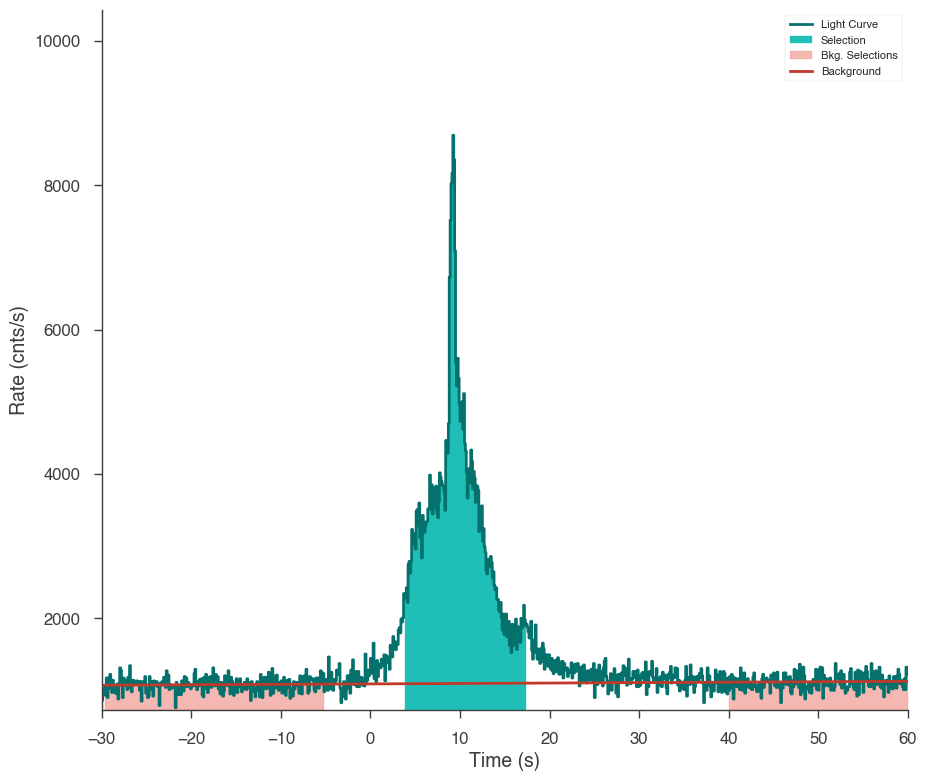

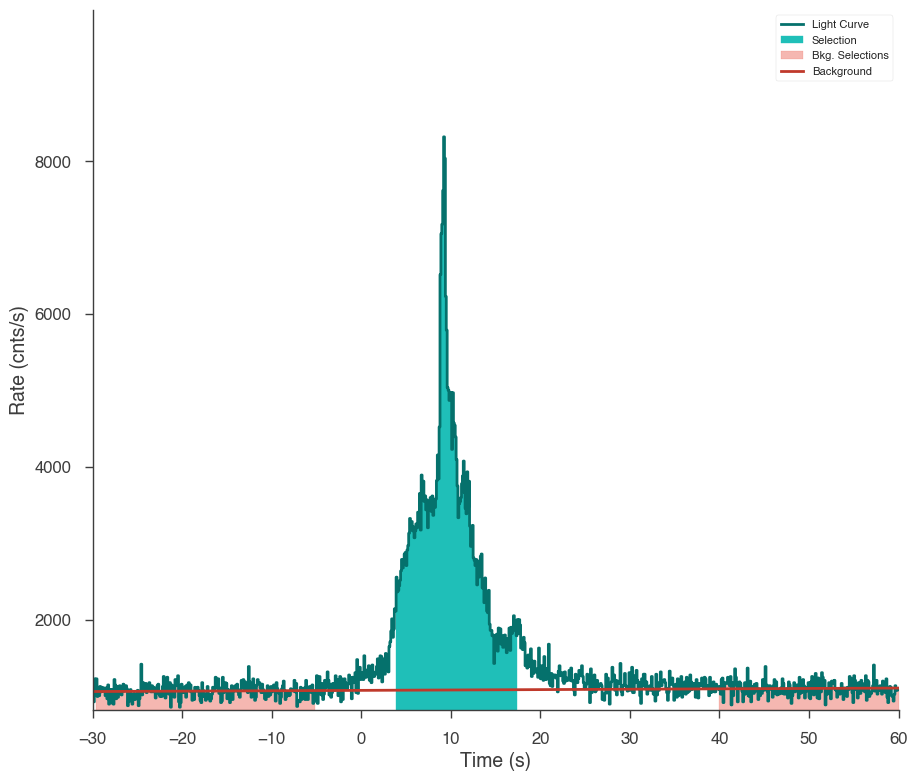

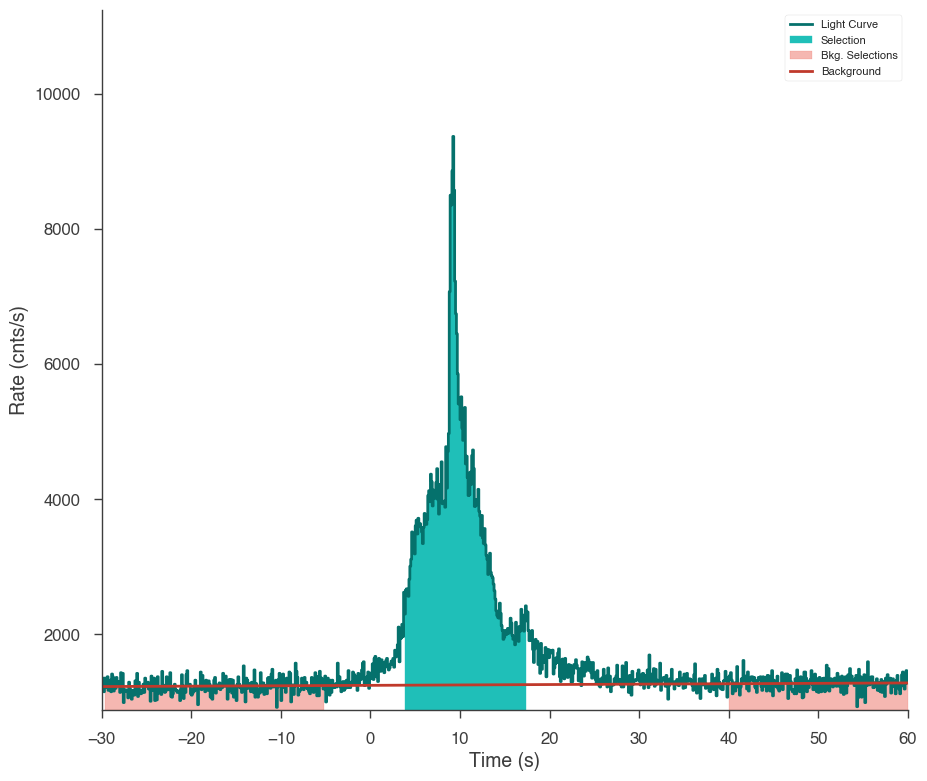

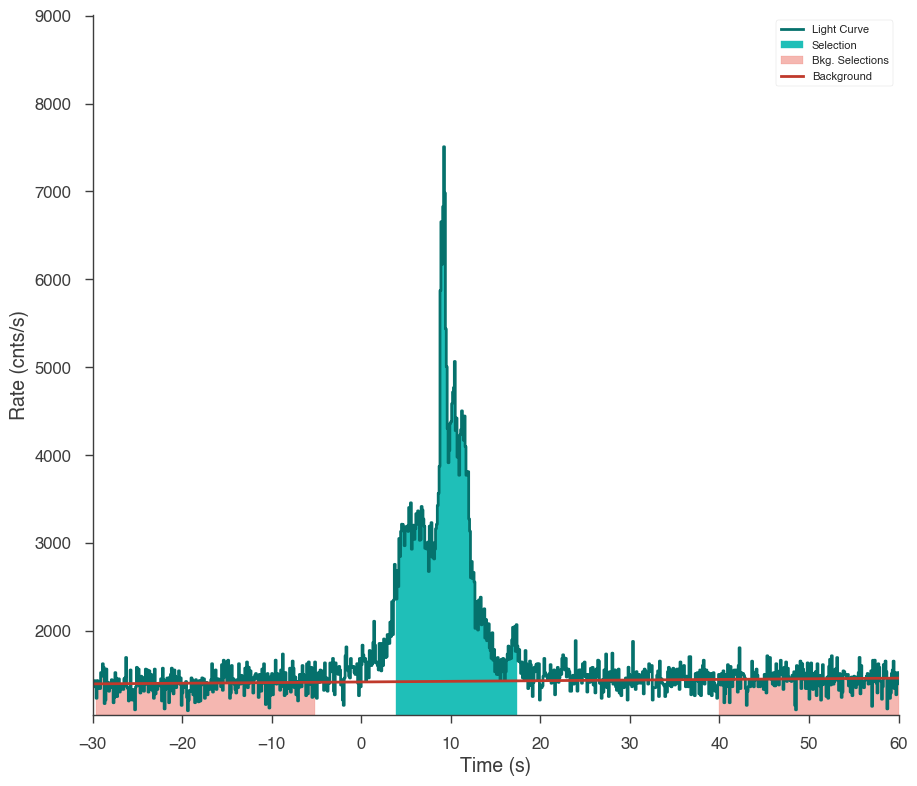

In [6]:
figures = query_catalog(dt=.1)

y = []
for fig in figures:
    x, curve, _ = get_curves(fig)
    print("Maximum %s at index %s, time %s"%(max(curve), 
                                             np.where(curve == max(curve))[0][0], 
                                             x[np.where(curve == max(curve))[0][0]]))
    y.append(curve)

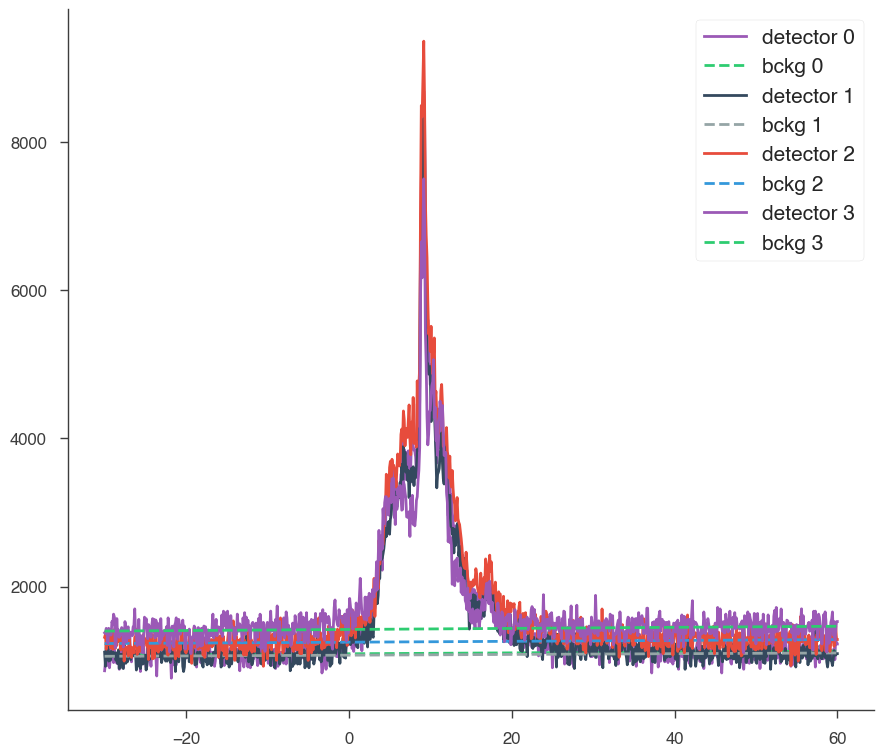

In [7]:
fig = show_curves(figures)
fig.show()

In [46]:
def detector_data_to_DataFrame(figures, GRBNAME):
    
    gbm_catalog.query_sources('GRB%s'%GRBNAME)
    grb_info = gbm_catalog.get_detector_information()['GRB%s'%GRBNAME]
    gbm_detectors = grb_info["detectors"]
    
    
    t = ['tau_' + item for item in gbm_detectors]
    bckg = [item + '_bckg' for item in gbm_detectors]
    
    data = pd.DataFrame()
        
    for i,fig in enumerate(figures):
        x, curve, bckg_data = get_curves(fig)
        
        data[t[i]]=pd.Series(x)
        data[gbm_detectors[i]] = pd.Series(curve)
        data[bckg[i]] = pd.Series(bckg_data)
    print('Saving to bn%s.csv'%GRBNAME)
    data.to_csv('bn%s.csv'%GRBNAME)
    
def retrieve_data(figures):
    y = None
    for fig in figures:
        x, curve, bckg_data = get_curves(fig)
        if y is None:
            y = curve-np.mean(bckg_data)
        else:
            y+=(curve-np.mean(bckg_data))
    return y/len(figures), x

Building our model to fit the lightcurve requires a couple components.

Firstly, the model needs to have one value per second interval to match the lightcurves. This will occupy the interval of the signal onset.

Second, we will want an afterglow ~ inverse powerlaw. This will be the interval following, showing the decay of the signal. We could start this decay from the maximum from the previous interval, but I think it's better to leave it open for now.
[Afterglow]()

Lastly there will be a background which contributes to the model evenly.

In [9]:
# With ultranest in mind, let's build out the model
import ultranest

# Assemble the data
data, time_domain = retrieve_data(figures)
# This data is the curve averaged over detectors - background. All we need is the model.

In [51]:
# We want this to base the EBH lifetime.
peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

"""
# Set bounds of modeling for the signal
lightcurve_open = np.where(x==-20)[0][0]
powerlaw_close = np.where(x==60)[0][0]
"""

# Data error 
error_tolerance = np.mean(data) * 0.001

param_names = ['K_lightcurve', 'K_powerlaw', 't_m_powerlaw', 't_p_powerlaw', 
               'delta_powerlaw', 'index_lightcurve'] # Normalization & steepness for exp. decay

def lightcurve_model(K_lightcurve, K_powerlaw, t_m_powerlaw, t_p_powerlaw, 
                     delta_powerlaw, index_lightcurve,
                     energy_range = np.linspace(Emin, Emax, 1000)):
    
    # Primary/secondary emission interval
    """
    tau = np.linspace(0.5, peak_index - lightcurve_open -.5, peak_index - lightcurve_open)
    """
    tau = np.linspace(peak_index, 0, peak_index, endpoint=False)
    
    curve = lightcurve(tau=tau, energy_range=energy_range, normalization=K_lightcurve, index = index_lightcurve)

    #curve = np.flip(curve)
    
    # Add afterglow element
    afterglow_curve = afterglow(tau=time_domain, delta = delta_powerlaw, t_p = t_p_powerlaw, t_m = t_m_powerlaw, normalization=K_powerlaw)
    # Assemble model
    model = np.zeros(len(data))
    model[0:peak_index]=curve
    #model[lightcurve_open:peak_index] = curve
    model = model + afterglow_curve


    return model

def likelihood_model(params):
    K_lightcurve, K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw, index_lightcurve = params
    
    curve = lightcurve_model(K_lightcurve, K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw, index_lightcurve)
    
    like = -0.5 * (((curve - data)/error_tolerance)**2).sum()
    #like = pearsonr(data,curve)[0]
    return like

def prior_transform(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3#1e-26
    hi = 1e6#1e-24
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

Peak index at 211


In [47]:
# Run fitting process
sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_transform)

result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+08  2e+08 [-2.234e+08..-2.234e+08]*| it/evals=34200/459327 eff=7.4522% N=400 
[ultranest] Likelihood function evaluations: 459327
[ultranest]   logZ = -2.234e+08 +- 0.229
[ultranest] Effective samples strategy satisfied (ESS = 2505.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.59, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.23 tail:0.01 total:0.23 required:<0.50
[ultranest] done iterating.

logZ = -223374814.038 +- 0.392
  single instance: logZ = -223374814.038 +- 0.225
  bootstrapped   : logZ = -223374814.090 +- 0.392
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: 28219 iterations

    K_lightcurve        3374.28 +- 0.36
    K_powerlaw          7604.41 +- 0.15
    t_m_powerlaw        1.261831 +- 0.000034
    t_p_powerlaw        2.31333 +- 0.00014
    delta_powerlaw      9.6

In [16]:
def plot_model(x, result = None, log=False, name='bn150902733', vals=None):
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_figwidth(18)
    
    if vals is None:
        vals = result['posterior']['mean']
    K_lightcurve = vals[0]
    K_powerlaw = vals[1]
    t_m_powerlaw = vals[2]
    t_p_powerlaw = vals[3]
    delta_powerlaw = vals[4]
    index_lightcurve = vals[5]
    
    ax1.scatter(x,data, s=30)
    ax2.scatter(x,data, s=30)
    
    fitted_model = lightcurve_model(K_lightcurve, K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw, index_lightcurve)
    r = pearsonr(data,fitted_model)
    ax1.plot(x, 
            fitted_model,
            label = 'r:%.4e  pval:%.4e'%(r[0],r[1]))

    curve = lightcurve(tau=np.linspace(peak_index, 0, peak_index, endpoint=False), 
                          energy_range=np.linspace(Emin, Emax, 1000), 
                          normalization=K_lightcurve)
    #curve = np.flip(curve)
    ax2.plot(x[0:peak_index], curve, label = 'simplified direct+frag emission')

    afterglow_curve = afterglow(tau=time_domain, delta = delta_powerlaw, t_p = t_p_powerlaw, t_m = t_m_powerlaw, normalization=K_powerlaw)
    ax2.plot(x, afterglow_curve, '--', label = r'afterglow $\frac{e^{Ax}}{1-e^{Bx}}$', color='orange')

    #plt.ylim(100,200)
    #ax2.ylim(-3500,6500)
    ax1.legend(prop={'size': 15})
    ax2.legend(prop={'size': 15})
    ax1.set_ylabel('Count rate (per second, binned on .1s)')
    ax1.set_xlabel('Time wrt to trigger time')
    #ax2.set_ylabel('Count rate')
    ax2.set_xlabel('Time wrt to trigger time')
    fig.suptitle('Composite Bayesian fit of %s'%name, size=15)
    
    std = result['posterior']['stdev']
    lc_txt="Lightcurve norm: %.4e +- %.2e & index: %.4f +- %.2f ; \n"%(vals[0], std[0], vals[5], std[5])
    pl_txt="Powerlaw norm: %.4e +- %.2e , t_m: %.4f +- %.2f , t_p: %.4f +- %.2f , delta: %.4f +- %.2f \n"%( 
        vals[1], std[1], vals[2], std[2], vals[3], std[3], vals[4], std[4] )
    fit_txt="logZ: %.4e +- %.2e (Z = marginal likelihood)"%(result['logz'], result['logzerr'])
    plt.figtext(0.5, 0.01, lc_txt + pl_txt + fit_txt, wrap=True, horizontalalignment='center', fontsize=13)
    
    if log:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    return fig

fig = plot_model(time_domain,result = result, log=False)


NameError: name 'result' is not defined

### <a id="candidates" style="color:black;">Expanding to other sources</a>
[back to top](#Top)

- [bn091031500](#09)
- [bn140206275](#14)
- bn150902733 was done in the example
- [bn150118409](#15)
- [bn160821857](#16)
- [bn180718763](#18)
- [bn190731943](#19)

The main difference in fitting between sources is the parameter bounds for normalization. This is why we expand them below here.

Mostly thinking 14,16,19

#### <a id="09" style="color:black;">bn0901031500</a>

- tau = [ -30 , 60 ]

- K_lightcurve = [ 10 , 1e5 ]
- K_powerlaw = [ 1 , 1e4 ]

In [ ]:
def prior_transform_09(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 10
    hi = 1e5
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

[back to candidates](#candidates)

#### <a id="14" style="color:black;">bn140206275</a>

- tau = [ -20 , 70 ]

- K_lightcurve = [ 1e3 , 1e5 ]
- K_powerlaw = [ 1 , 1e4 ]

['n0' 'n1' 'n3' 'b0']


Loading PHAII Spectra:   0%|                           | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

21:38:25 INFO      Auto-determined polynomial order: 1                                ]8;id=795531;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=843627;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

21:38:36 INFO      None 1-order polynomial fit with the mle method                               ]8;id=433162;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=815307;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n0_bkg.h5                                         ]8;id=837358;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=811653;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n0_bkg.h5                                         ]8;id=906184;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=712605;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

21:38:38 INFO      Successfully restored fit from n0_bkg.h5                              ]8;id=87276;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=767406;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 7.488-154.178 for n0                                  ]8;id=515466;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=126060;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

21:38:44 INFO      Auto-determined polynomial order: 3                                ]8;id=996689;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=209696;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

21:38:59 INFO      None 3-order polynomial fit with the mle method                               ]8;id=917722;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=568096;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=759915;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=181019;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=991988;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=659702;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

21:39:00 INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=559867;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=150631;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 7.488-154.178 for n1                                  ]8;id=407795;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=314334;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

21:39:07 INFO      Auto-determined polynomial order: 3                                ]8;id=616537;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=807000;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_03 background:   0%|                    | 0/128 [00:00<?, ?it/s]

21:39:21 INFO      None 3-order polynomial fit with the mle method                               ]8;id=581360;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=254567;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=450762;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=551231;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=586871;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=988704;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

21:39:22 INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=380182;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=584288;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

21:39:23 INFO      Interval set to 7.488-154.178 for n3                                  ]8;id=359322;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=616834;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

21:39:29 INFO      Auto-determined polynomial order: 1                                ]8;id=792397;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=888759;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

21:39:41 INFO      None 1-order polynomial fit with the mle method                               ]8;id=466377;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=843166;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=342186;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=780600;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=616879;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=802486;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

21:39:42 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=141155;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=108120;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 7.488-154.178 for b0                                  ]8;id=916903;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=23499;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

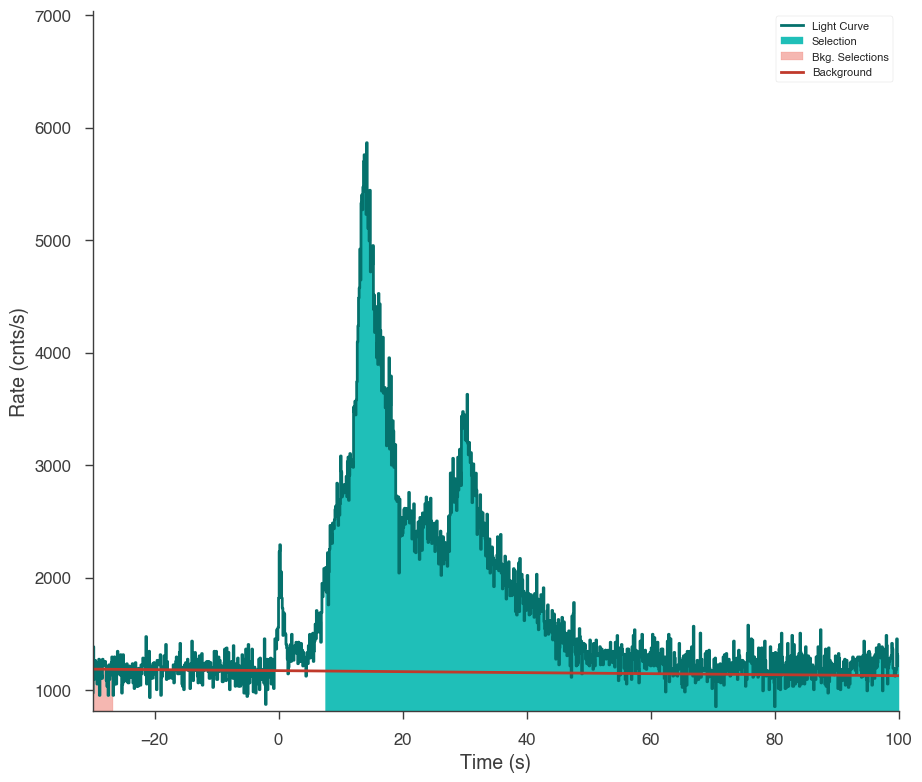

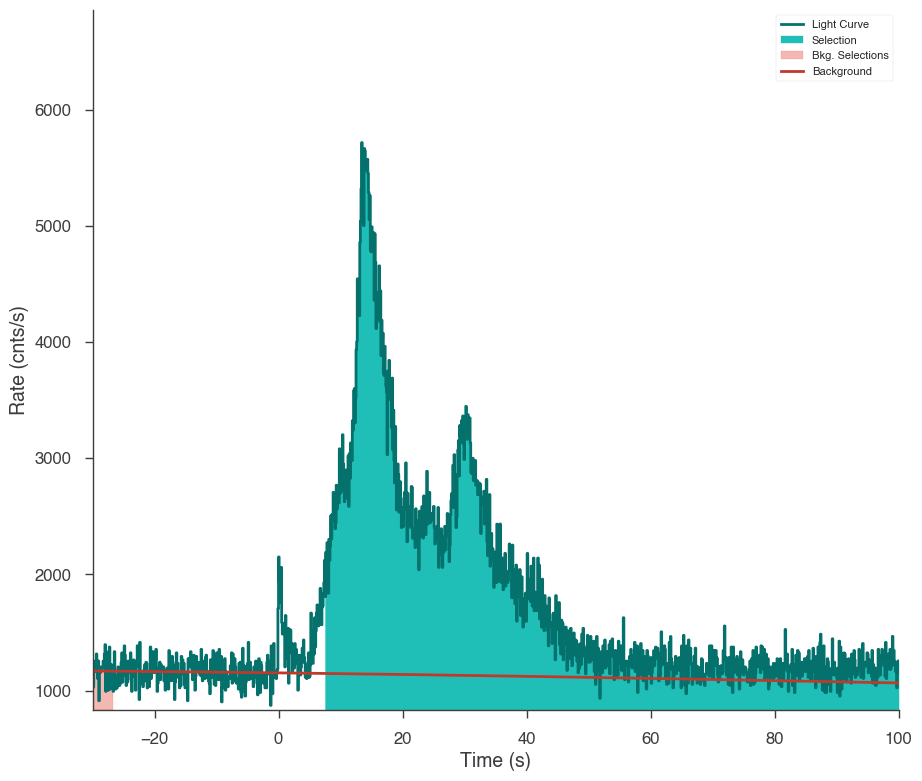

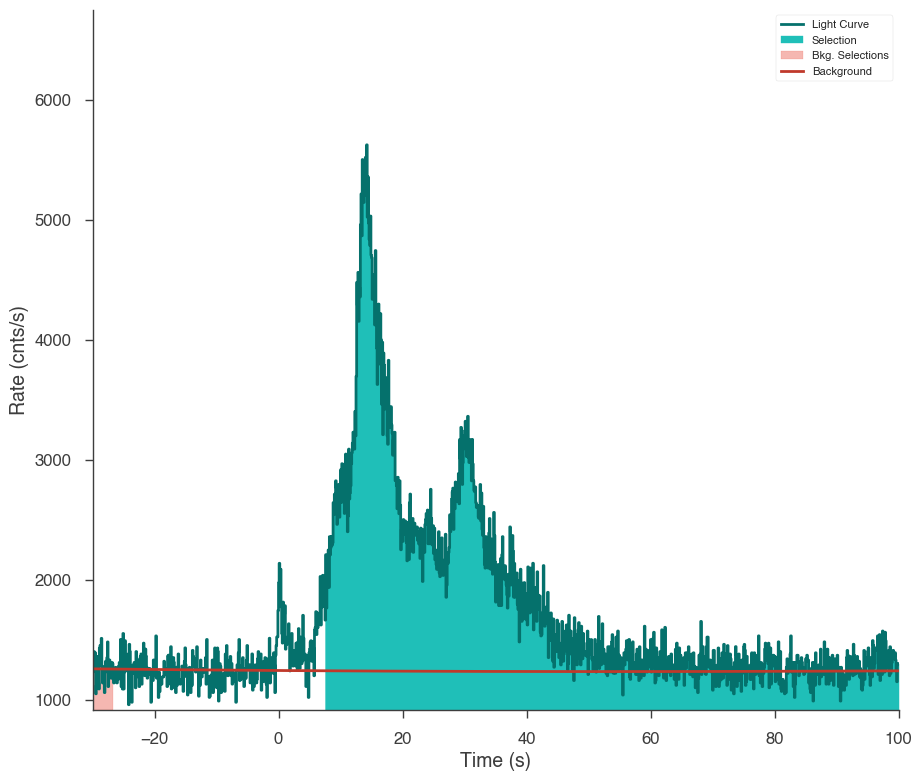

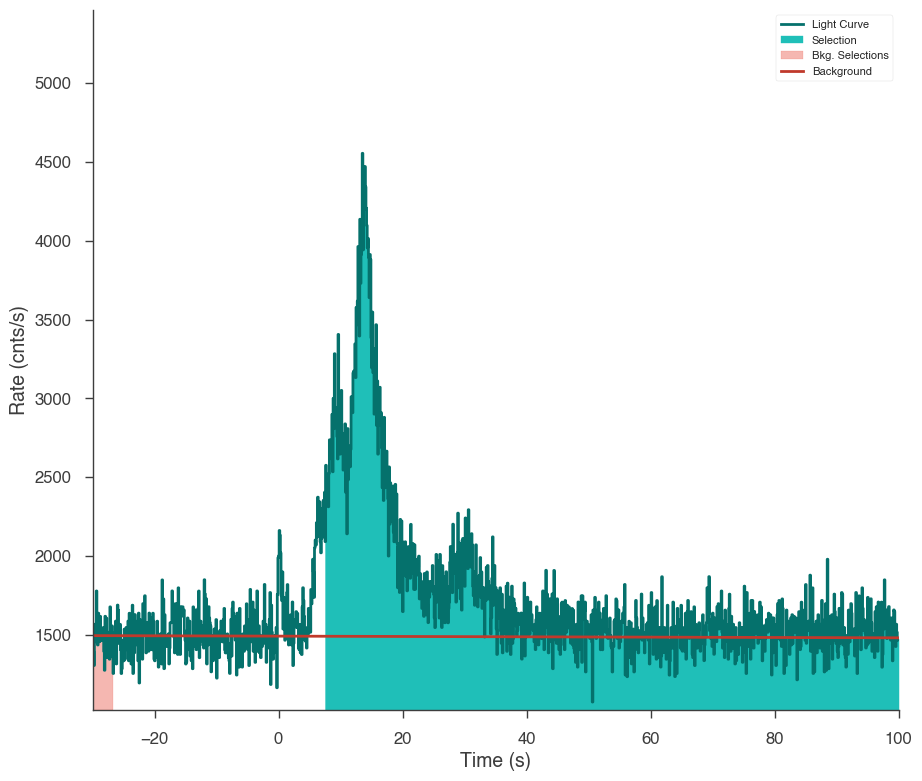

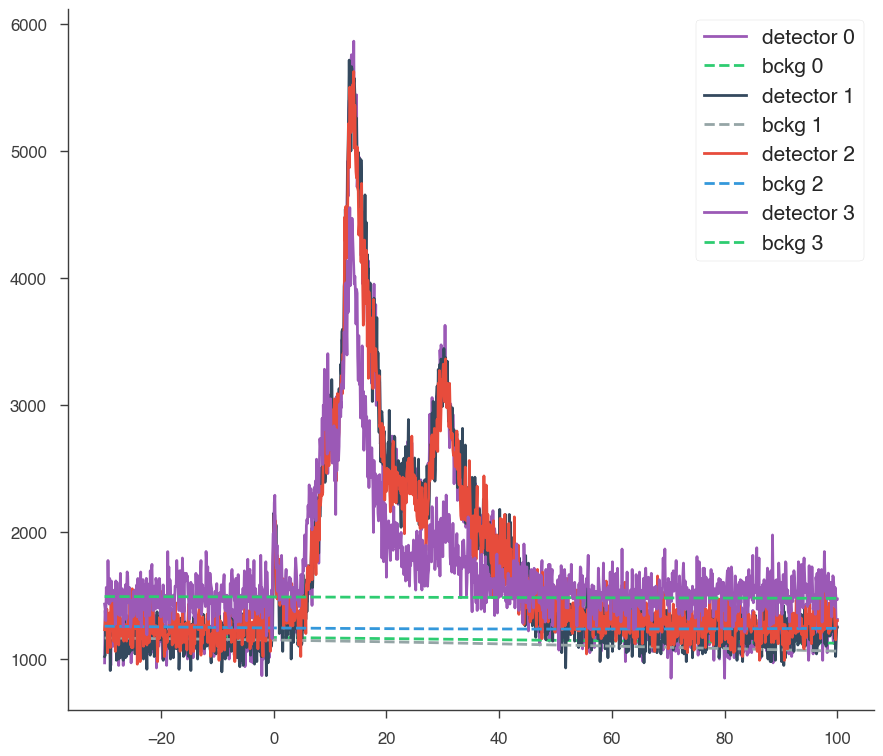

In [40]:
figures = query_catalog(GRBNAME = '140206275', time_in = -30, time_out = 100,dt=.1)

data, time_domain = retrieve_data(figures)
fig = show_curves(figures)
fig.show()

In [41]:
def prior_transform_14(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3
    hi = 1e5
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

Peak index at 439
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+03  899.88 [-1900.2733..-1900.2719]*| it/evals=17600/282066 eff=6.2485% N=400    00 0 
[ultranest] Likelihood function evaluations: 282136
[ultranest]   logZ = -1940 +- 0.2027
[ultranest] Effective samples strategy satisfied (ESS = 2494.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.16 to 0.51, need <0.5)
[ultranest]   logZ error budget: single: 0.30 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.

logZ = -1939.631 +- 0.507
  single instance: logZ = -1939.631 +- 0.303
  bootstrapped   : logZ = -1939.638 +- 0.507
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    K_lightcurve        : 1483  │ ▁▁▁▁▁▁▁▁▂▂▃▃▄▅▇▇▇▇▇▆▆▅▄▃▂▂▁▁▁▁▁▁▁▁  ▁ │2521      1970 +- 122
    K_powerlaw          : 3308  │ ▁▁ ▁▁▁▁▁▁▁▁▂▂▃▃▅▆▆▆▇▆▅▆▄▃▃▂▁▁▁▁▁▁▁▁▁▁ │3640     

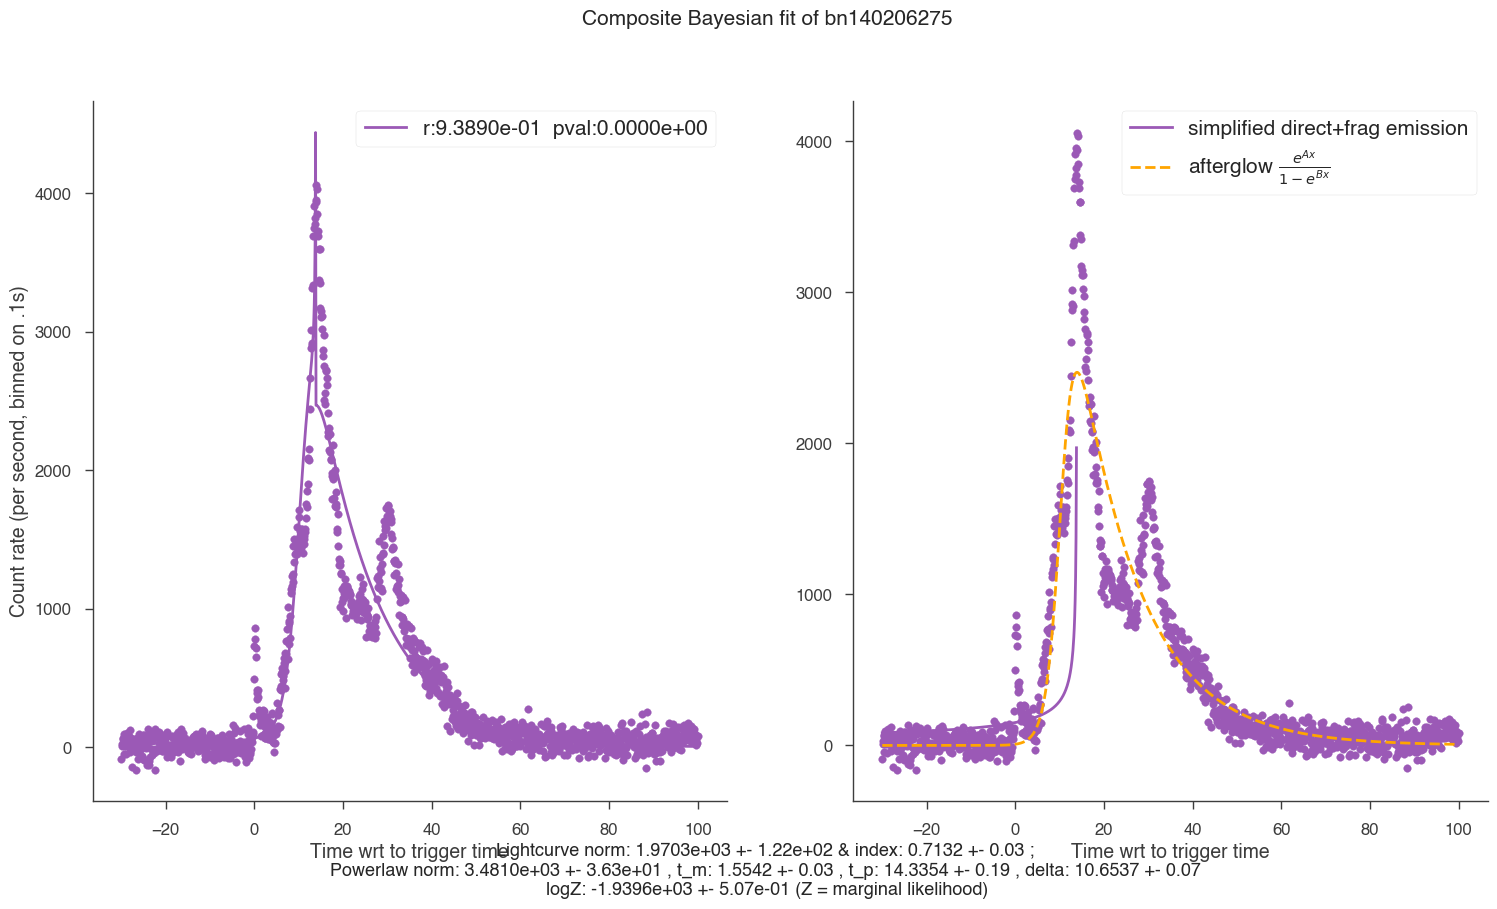

In [43]:
bckg_data=[]
for fig in figures:
    _,_, b = get_curves(fig)
    bckg_data.append(b)
error_tolerance = np.std(bckg_data)

peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_transform_14)

result14 = sampler.run()
sampler.print_results()

fig = plot_model(time_domain, result = result14, log=False, name = 'bn140206275')

[back to candidates](#candidates)

#### <a id="15" style="color:black;">bn150118409</a>

- tau = [ -20 , 70 ]

- K_lightcurve = [ 1e3 , 1e5 ]
- K_powerlaw = [ 1 , 1e4 ]

In [ ]:
def prior_transform_15(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3
    hi = 1e5
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

[back to candidates](#candidates)

#### <a id="16" style="color:black;">bn160821857</a>

- tau = [ -20 , 40 ]

- K_lightcurve = [ 1e3 , 1e7 ]
- K_powerlaw = [ 1 , 1e6 ]

In [ ]:
figures = query_catalog(GRBNAME = '160821857', time_in = 100, time_out = 200,dt=.1)

data, time_domain = retrieve_data(figures)
fig = show_curves(figures)
fig.show()

In [32]:
def prior_transform_16(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 5*1e3
    hi = 1e6
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e5
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = 100
    hi = 180
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

Peak index at 357
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+03  352.07 [-1352.5601..-1352.5600]*| it/evals=20120/1321167 eff=1.5234% N=400   0   0  0 
[ultranest] Likelihood function evaluations: 1321182
[ultranest]   logZ = -1398 +- 0.245
[ultranest] Effective samples strategy satisfied (ESS = 2743.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.19 to 0.54, need <0.5)
[ultranest]   logZ error budget: single: 0.33 bs:0.24 tail:0.01 total:0.25 required:<0.50
[ultranest] done iterating.

logZ = -1398.111 +- 0.542
  single instance: logZ = -1398.111 +- 0.326
  bootstrapped   : logZ = -1398.123 +- 0.542
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    K_lightcurve        : 5000  │▇▆▅▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁  ▁ │5451      5050 +- 48
    K_powerlaw          : 19790 │ ▁▁ ▁▁▁▁▁▁▁▂▂▃▄▄▅▇▇▇▇▇▇▆▅▄▃▃▂▁▁▁▁▁▁▁▁▁ │20693 

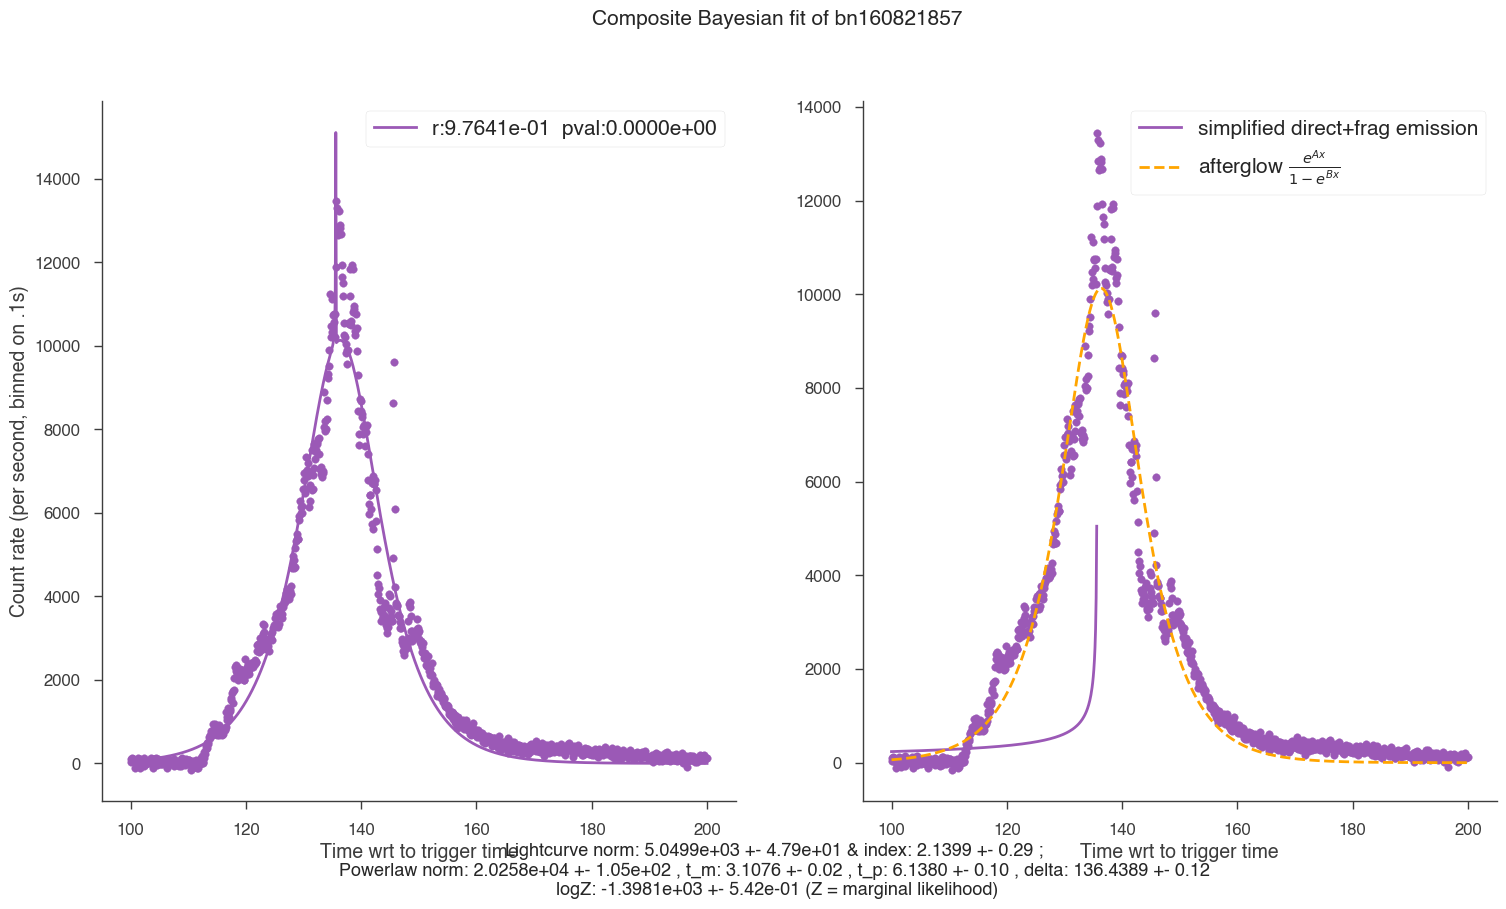

In [33]:
bckg_data=[]
for fig in figures:
    _,_, b = get_curves(fig)
    bckg_data.append(b)
error_tolerance = np.std(bckg_data)

peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_transform_16)

result16 = sampler.run()
sampler.print_results()

fig = plot_model(time_domain, result = result16, log=False, name = 'bn160821857')

[back to candidates](#candidates)

#### <a id="18" style="color:black;">bn180718763</a>

- tau = [ -20 , 40 ]

- K_lightcurve = [ 10 , 1e5 ]
- K_powerlaw = [ 1 , 1e4 ]

In [ ]:
def prior_transform_18(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3
    hi = 1e7
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e6
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

[back to candidates](#candidates)

#### <a id="19" style="color:black;">bn190731943</a>

- tau = [ -20 , 40 ]

- K_lightcurve = [ 10 , 1e5 ]
- K_powerlaw = [ 1 , 1e4 ]

['n6', 'n7', 'n8', 'n9', 'na', 'nb', 'b1']


19:59:06 INFO      file glg_cspec_n6_bn190731943_v00.pha is already downloaded!           ]8;id=666209;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=572643;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

19:59:07 INFO      file glg_cspec_n6_bn190731943_v02.rsp2 is already downloaded!          ]8;id=591674;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=837856;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n6_bn190731943_v00.fit is already downloaded!             ]8;id=878168;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=382870;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

19:59:08 INFO      file glg_cspec_n7_bn190731943_v00.pha is already downloaded!           ]8;id=585214;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=869238;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n7_bn190731943_v02.rsp2 is already downloaded!          ]8;id=529963;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=821688;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n7_bn190731943_v00.fit is already downloaded!             ]8;id=956811;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=808684;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

19:59:09 INFO      file glg_cspec_n8_bn190731943_v00.pha is already downloaded!           ]8;id=505566;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=357430;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n8_bn190731943_v02.rsp2 is already downloaded!          ]8;id=264341;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=846744;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:00:40 INFO      Auto-determined polynomial order: 0                                ]8;id=555291;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=194057;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_06 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:00:52 INFO      None 0-order polynomial fit with the mle method                               ]8;id=401438;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=982543;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n6_bkg.h5                                         ]8;id=573091;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=259274;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

20:00:53 INFO      Saved background to n6_bkg.h5                                         ]8;id=408226;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=57128;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n6_bkg.h5                              ]8;id=66976;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=394933;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.792-17.664 for n6                                   ]8;id=393246;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=625908;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:00:57 INFO      Auto-determined polynomial order: 0                                ]8;id=880850;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=806789;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_07 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:01:10 INFO      None 0-order polynomial fit with the mle method                               ]8;id=68267;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=272444;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n7_bkg.h5                                         ]8;id=655256;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=450752;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n7_bkg.h5                                         ]8;id=182190;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=934474;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n7_bkg.h5                              ]8;id=465465;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=681041;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

20:01:11 INFO      Interval set to 1.792-17.664 for n7                                   ]8;id=916731;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=337867;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:01:16 INFO      Auto-determined polynomial order: 0                                ]8;id=711435;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=658853;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_08 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:01:29 INFO      None 0-order polynomial fit with the mle method                               ]8;id=566460;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=239548;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n8_bkg.h5                                         ]8;id=22173;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=910690;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n8_bkg.h5                                         ]8;id=238365;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=761162;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n8_bkg.h5                              ]8;id=147109;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=180948;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

20:01:30 INFO      Interval set to 1.792-17.664 for n8                                   ]8;id=946942;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=653560;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:01:33 INFO      Auto-determined polynomial order: 0                                ]8;id=489814;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=768930;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_09 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:01:45 INFO      None 0-order polynomial fit with the mle method                               ]8;id=926462;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=321912;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n9_bkg.h5                                         ]8;id=489938;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=305729;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n9_bkg.h5                                         ]8;id=903578;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=762200;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

20:01:46 INFO      Successfully restored fit from n9_bkg.h5                              ]8;id=839097;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=456413;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.792-17.664 for n9                                   ]8;id=443775;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=203400;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:01:49 INFO      Auto-determined polynomial order: 0                                ]8;id=558612;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=671965;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_10 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:02:01 INFO      None 0-order polynomial fit with the mle method                               ]8;id=651970;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=36506;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to na_bkg.h5                                         ]8;id=981567;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=493756;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to na_bkg.h5                                         ]8;id=489509;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=353555;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from na_bkg.h5                              ]8;id=808418;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=484124;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

20:02:02 INFO      Interval set to 1.792-17.664 for na                                   ]8;id=883110;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=484948;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:02:06 INFO      Auto-determined polynomial order: 0                                ]8;id=329440;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=228667;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_11 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:02:19 INFO      None 0-order polynomial fit with the mle method                               ]8;id=668688;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=451285;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to nb_bkg.h5                                         ]8;id=275833;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=768305;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to nb_bkg.h5                                         ]8;id=814385;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=338382;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from nb_bkg.h5                              ]8;id=135183;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=243637;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.792-17.664 for nb                                   ]8;id=71020;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=567824;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:02:24 INFO      Auto-determined polynomial order: 0                                ]8;id=633602;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=442250;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:02:38 INFO      None 0-order polynomial fit with the mle method                               ]8;id=195374;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=157112;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b1_bkg.h5                                         ]8;id=143130;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=319279;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b1_bkg.h5                                         ]8;id=833228;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=942576;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

20:02:39 INFO      Successfully restored fit from b1_bkg.h5                              ]8;id=118927;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=780516;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.792-17.664 for b1                                   ]8;id=549120;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=307809;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

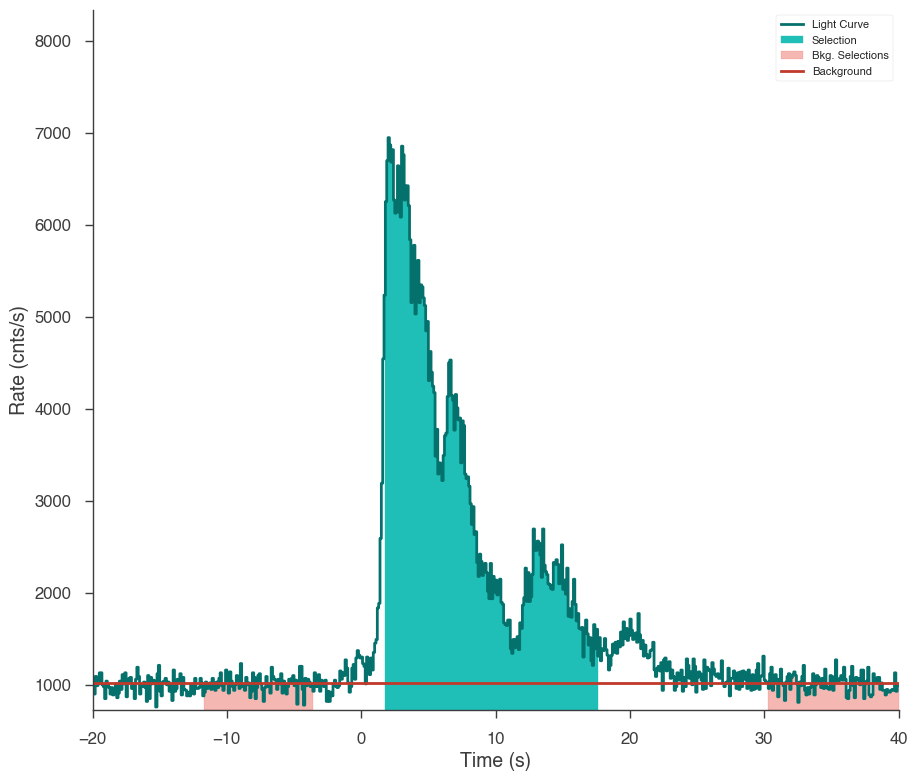

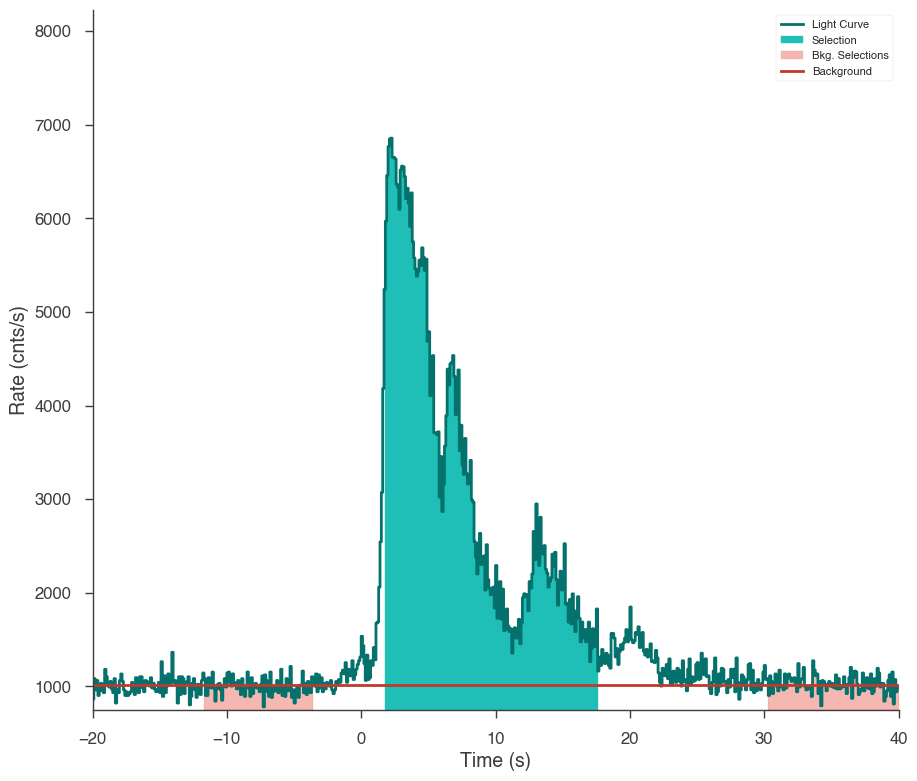

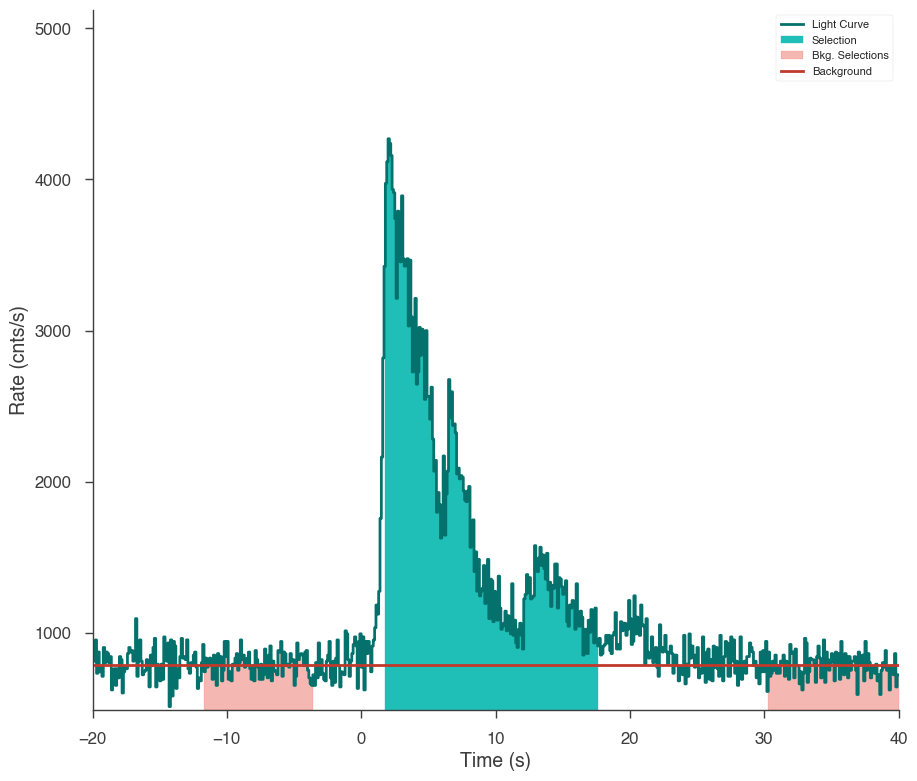

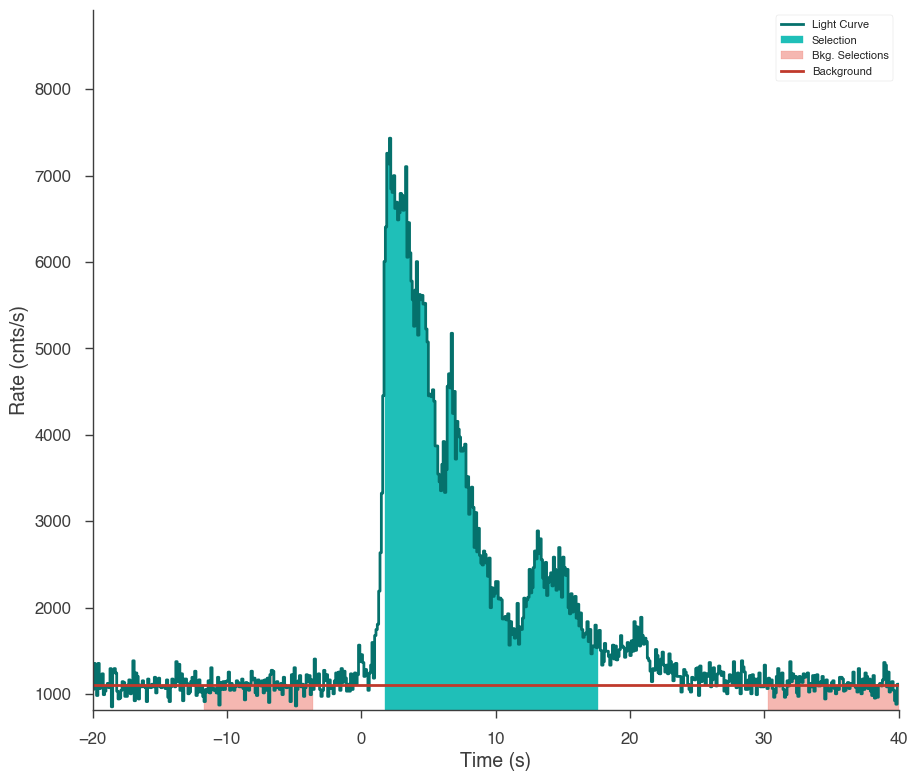

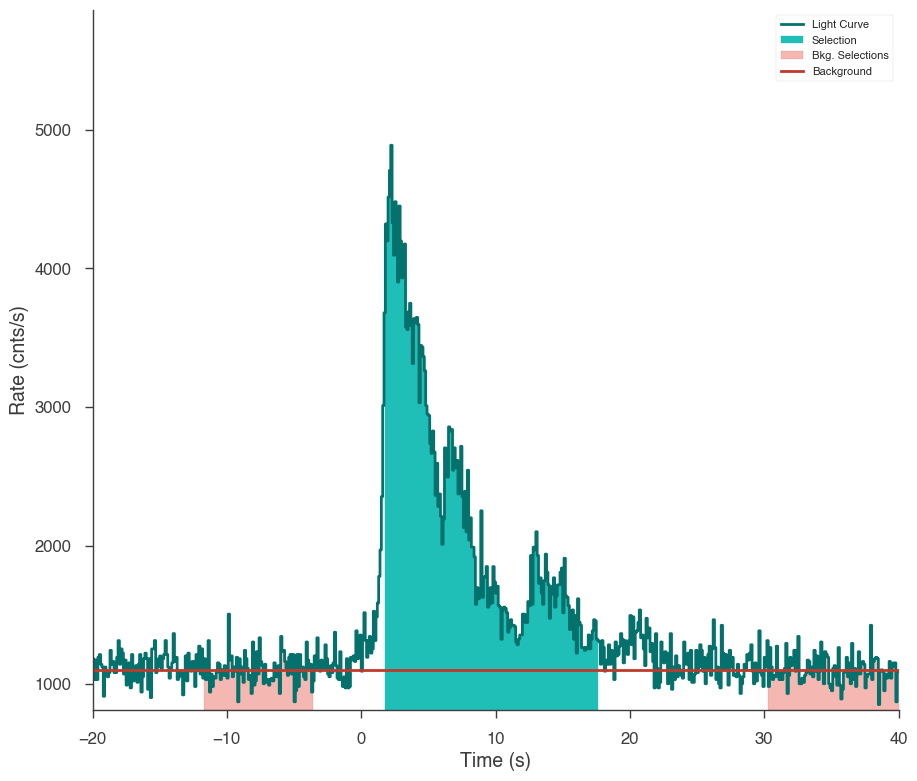

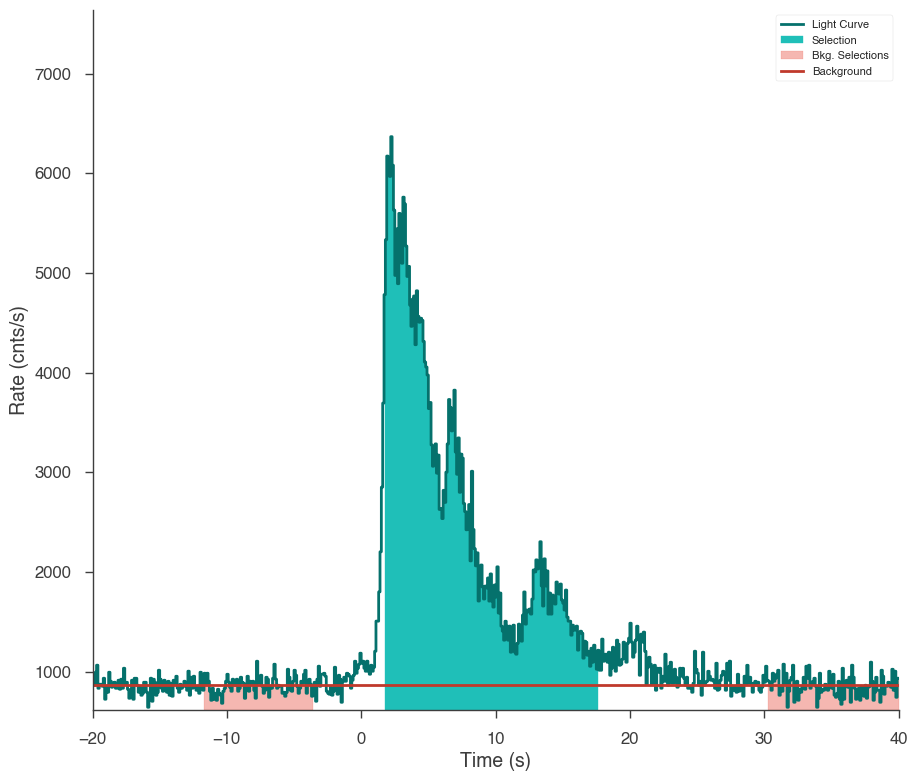

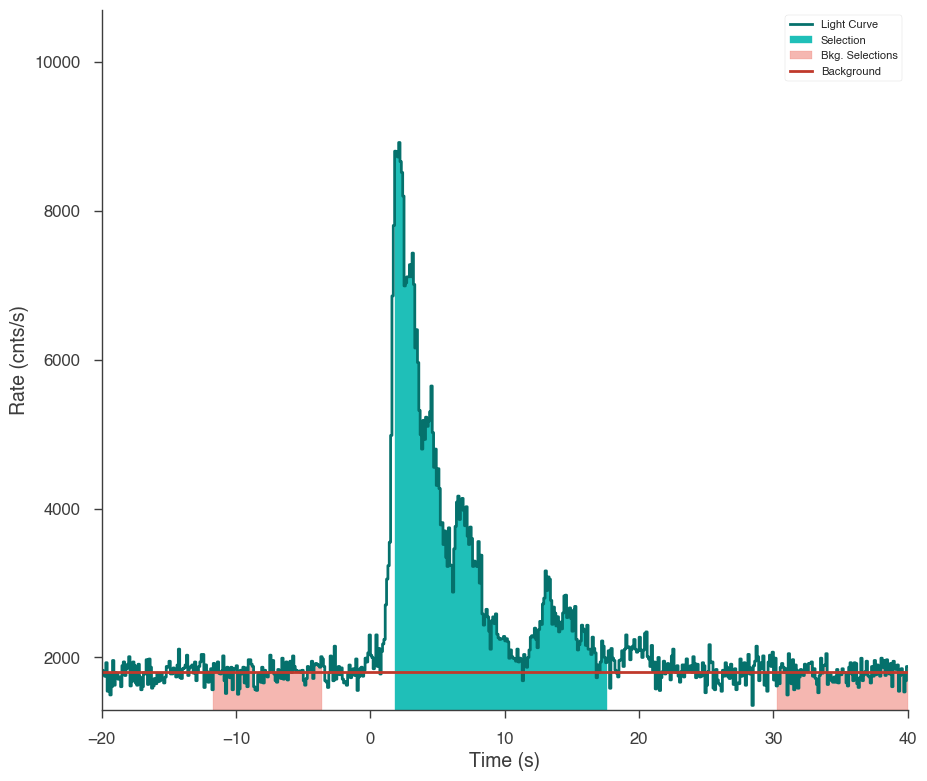

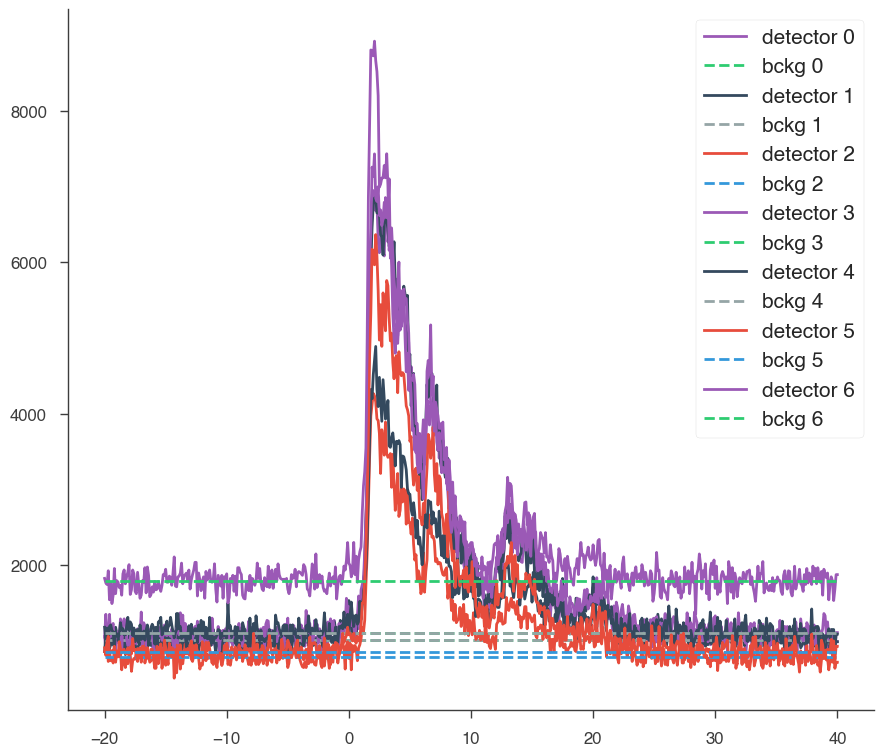

In [35]:
figures = query_catalog(GRBNAME = '190731943', time_in = -20, time_out = 40,dt=.1, gbm_detectors = ['n6', 'n7', 'n8', 'n9', 'na', 'nb', 'b1'])

data, time_domain = retrieve_data(figures)
fig = show_curves(figures)
fig.show()

In [36]:
def prior_transform_19(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3
    hi = 1e5
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

In [38]:
bckg_data=[]
for fig in figures:
    _,_, b = get_curves(fig)
    bckg_data.append(b)
error_tolerance = np.std(bckg_data)

peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_transform_19)

result19 = sampler.run()
sampler.print_results()

Peak index at 221
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+02  .83 [-141.3571..-141.3558]*| it/evals=17600/470757 eff=3.7418% N=400    00 0 
[ultranest] Likelihood function evaluations: 470866
[ultranest]   logZ = -180.6 +- 0.1965
[ultranest] Effective samples strategy satisfied (ESS = 2586.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.20, need <0.5)
[ultranest]   logZ error budget: single: 0.30 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.

logZ = -180.653 +- 0.460
  single instance: logZ = -180.653 +- 0.302
  bootstrapped   : logZ = -180.648 +- 0.460
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    K_lightcurve        : 1000  │▇▆▅▅▄▃▃▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁  ▁ │1962      1130 +- 117
    K_powerlaw          : 5464  │ ▁ ▁▁▁▁▁▁▁▁▂▃▄▅▅▆▆▇▇▇▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁ │6355      5902 +- 101
    t_m_powerlaw        

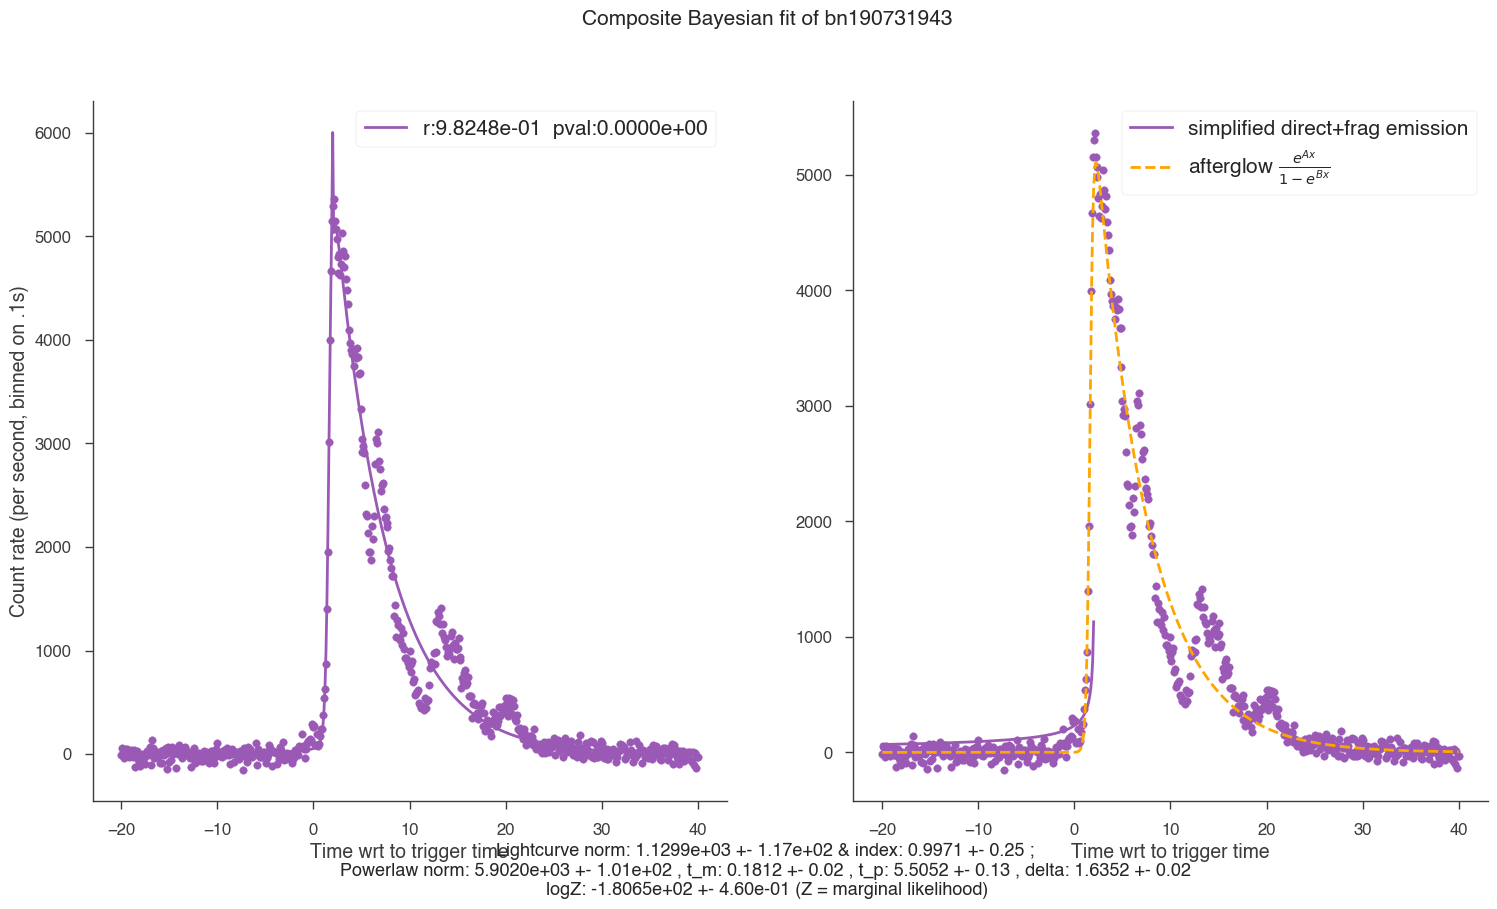

In [39]:
fig = plot_model(time_domain, result = result19, log=False, name='bn190731943')

Miscellaneous possible candidates

- 180305393 (Weirdly high error)

- 131216081
- 121225417
- 150416773
- 160101215

Top short burst duration

- 090531775
- 130310840
- 160325291

['n9']


22:53:18 INFO      file glg_cspec_n9_bn130310840_v00.pha is already downloaded!           ]8;id=244326;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=157694;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n9_bn130310840_v03.rsp is already downloaded!           ]8;id=343139;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=186517;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n9_bn130310840_v00.fit is already downloaded!             ]8;id=739650;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=257457;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/1854 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

22:53:21 INFO      Auto-determined polynomial order: 0                                ]8;id=801387;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=239813;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_09 background:   0%|                    | 0/128 [00:00<?, ?it/s]

22:53:34 INFO      None 0-order polynomial fit with the mle method                               ]8;id=560763;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=487363;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n9_bkg.h5                                         ]8;id=696062;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=751716;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n9_bkg.h5                                         ]8;id=663446;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=128365;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n9_bkg.h5                              ]8;id=689791;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=611272;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 4.096-20.096 for n9                                   ]8;id=367626;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=173394;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

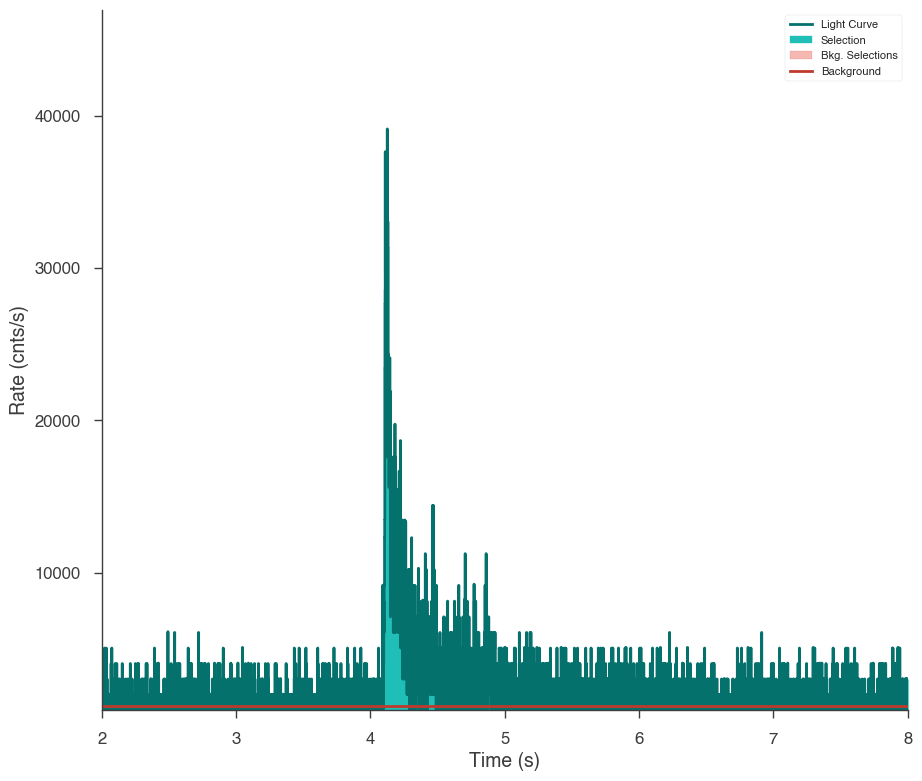

In [60]:
GRBNAME = '130310840'

figures = query_catalog(GRBNAME = GRBNAME, 
                        time_in = 2, time_out = 8, dt=1e-3,
                        gbm_detectors = ['n9'])

Text(0.5, 0, 's')

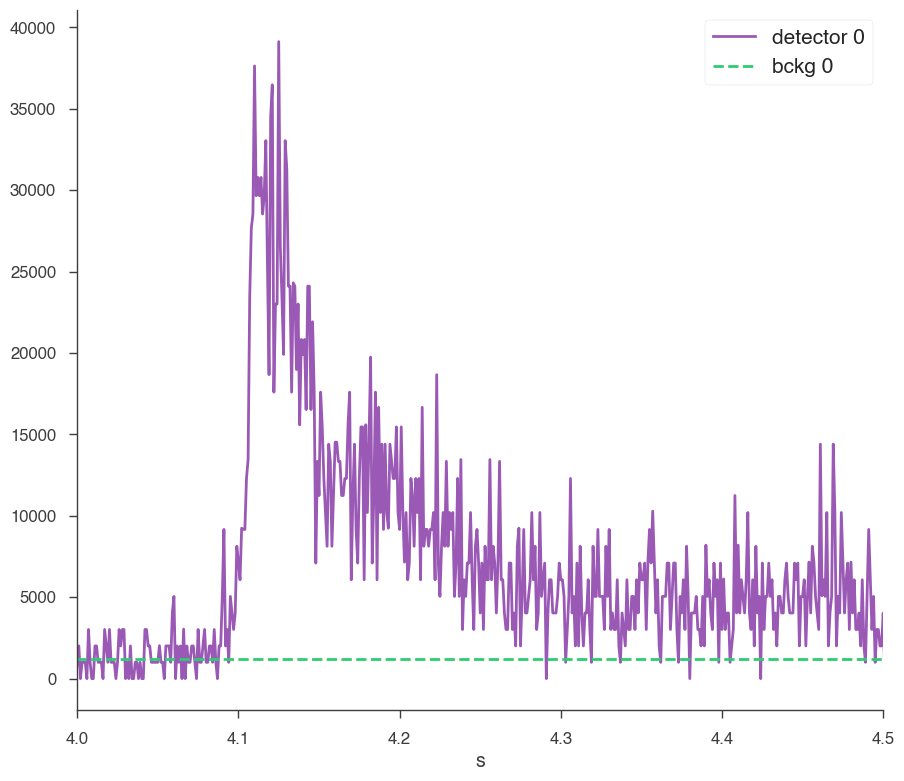

In [64]:
fig = show_curves(figures)
ax = fig.get_axes()[0]
ax.set_xlim(4,4.5)
ax.set_xlabel('s')
# Looks quite similar to Figure 5 in the Cline '97 paper

In [47]:
def prior_transform_13(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3
    hi = 1e5
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

data, time_domain = retrieve_data(figures)

In [56]:
bckg_data=[]
for fig in figures:
    _,_, b = get_curves(fig)
    bckg_data.append(b)
error_tolerance = 1e2#np.std(bckg_data)
print('Using error tolerance of %3e'%error_tolerance)

peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_transform_13)

result19 = sampler.run()
sampler.print_results()

Using error tolerance of 1.000000e+02
Peak index at 211
[ultranest] Sampling 400 live points from prior ...


KeyboardInterrupt: 

### <a id="fitting" style="color:black;">Fitting GRB spectrum to spectral model</a>
[back to top](#Top)

Let's make a custom model to plug into 3ML so we can fit the spectrum.

[Tutorial for model-building (3ml)](https://notebook.community/giacomov/3ML/docs/notebooks/spectral_models)

[Tutorial for model-building (astromodels)](https://astromodels.readthedocs.io/en/latest/notebooks/Functions_tutorial.html#Creating-custom-functions)

[Tutorial for time-dependent energy fit](https://threeml.readthedocs.io/en/stable/notebooks/Time-energy-fit.html)

In [5]:
gbm_catalog.query_sources("GRB150118409")

grb_info = gbm_catalog.get_detector_information()["GRB150118409"]

gbm_detectors = grb_info["detectors"]
print(gbm_detectors)
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
#best_fit_model = grb_info["best fit model"]["fluence"]
#model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB150118409"]

dload = download_GBM_trigger_data("bn150118409", detectors=gbm_detectors)

fluence_plugins = []
time_series = {}
figures = []
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    figures.append(ts_tte.view_lightcurve(-40, 100))

"""    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)
"""

['n1' 'n2' 'n5' 'b0']


In [58]:
import astropy.units as astropy_units
from astromodels.functions.function import Function1D, FunctionMeta, ModelAssertionViolation

p_s = photon_spectrum()
#time=20

class EBH_energy(Function1D, metaclass=FunctionMeta):
        r"""
        description :
            Energy spectrum of an evaporating black hole
        latex : $K*\phi_{\gamma}(E,\tau)$
        parameters :
            K :
                desc : Normalization
                initial value : 1.0
                is_normalization : True
                transformation : log10
                min : 1e-50
                max : 1e3
                delta : 0.1
            time :
                desc: lifetime remaining for the BH
                initial value: 20
                min: 0.
                max: 100.
        """

        #__metaclass__ = FunctionMeta

        def _set_units(self, x_unit, y_unit):
            
            # Distance of source measured in parsecs
            #self.distance.unit = astropy_units.parsec
            
            # Time remaining on BH lifetime
            self.time.unit = astropy_units.second   
            
            self.K.unit = y_unit
            
        # noinspection PyPep8Naming
        def evaluate(self, x, K, time):
            
            #xx = self.distance_scale(x, distance, time)
            
            # The p_s class allows energies in GeV
            # x from 3ML will be in keV
            xx = p_s(x* 10**(-6), time)# Manually convert 10^9 eV values to 10^3 eV values
            # resulting flux will be in /Gev/s
            # from 3ML will be in /keV/s
            xx*=(10**-6) # from 1/10^9 to 1/10^3
            return K*xx
        
#class EBH_time_evo(Function1D):


"""
            distance : 
                desc: distance from the source
                initial value: 0.0015
                min: 0.
                max: 1.
        def distance_scale(self, E, d, tau):
            
            
            spectrum = p_s(E, tau)
            
            return spectrum / (4*np.pi* d**2)
            
"""

'\n            distance : \n                desc: distance from the source\n                initial value: 0.0015\n                min: 0.\n                max: 1.\n        def distance_scale(self, E, d, tau):\n            \n            \n            spectrum = p_s(E, tau)\n            \n            return spectrum / (4*np.pi* d**2)\n            \n'

In [126]:
# Instantiate energy EBH model
spectrum = EBH_energy()

# Instantiate pointsource
src = PointSource("GRB150118409", ra=grb_info['ra'], dec=grb_info['dec'], spectral_shape=spectrum)

# Instantiate model
model = Model(src)

# Time-dependence
time = IndependentVariable("time", 1.0, u.s)
time_dep = Line()
#print(list_functions()[28])
model.add_independent_variable(time)

# Link time parameters
model.link(spectrum.time, time, time_dep)

# Let's define some priors
#model.GRB150118409.spectrum.main.EBH_energy.distance.prior = Uniform_prior(lower_bound=10e-5, upper_bound=1.)
model.GRB150118409.spectrum.main.EBH_energy.time.Line.a = -1.
model.GRB150118409.spectrum.main.EBH_energy.time.Line.a.free = False
model.GRB150118409.spectrum.main.EBH_energy.time.Line.b = 46#.prior = Uniform_prior(lower_bound=0, upper_bound=1000.)
model.GRB150118409.spectrum.main.EBH_energy.time.Line.b.free = False

model.GRB150118409.spectrum.main.EBH_energy.K.prior = Uniform_prior(lower_bound=1e-50, upper_bound=1e-10)
#model.GRB150118409.spectrum.main.EBH_energy.time.prior = Uniform_prior(lower_bound=1e-30, upper_bound=1e3)

# This is the completed model
model.display(complete=True)

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (1):
--------------------

                                        value min_value max_value  \
GRB150118409.spectrum.main.EBH_energy.K   1.0       0.0    1000.0   

                                                   unit  
GRB150118409.spectrum.main.EBH_energy.K  keV-1 s-1 cm-2  

Fixed parameters (4):
---------------------

                            value min_value max_value unit
GRB150118409.position.ra   339.94       0.0     360.0  deg
GRB150118409.position.dec  -76.62     -90.0      90.0  deg
GRB150118409...a             -1.0      None      None    s
GRB150118409...b             46.0      None      None     

Properties (0):
--------------------

(none)


Linked parameters (1):
----------------------

              GRB150118409.spectrum.main.EBH_energy.time
current value                                       45.0
function                                            Line
linked to                                           time
unit                                                   s


Independent variables:
----------------------

              time
current value  1.0
unit             s


Linked functions (0):
----------------------

(none)

Loading PHAII Spectra:   0%|          | 0/2033 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO    ] Auto-determined polynomial order: 1


Fitting GBM_NAI_01 background:   0%|          | 0/128 [00:00<?, ?it/s]

[INFO    ] None 1-order polynomial fit with the bayes method
[INFO    ] Saved fitted background to n1_bkg.h5
[INFO    ] Saved background to n1_bkg.h5
[INFO    ] Successfully restored fit from n1_bkg.h5
[INFO    ] Interval set to 7.68-47.873 for n1
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: gaussian
[INFO    ] Range 9-900 translates to channels 5-123
[INFO    ] Now using 119 bins


Loading PHAII Spectra:   0%|          | 0/2033 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO    ] Auto-determined polynomial order: 1


Fitting GBM_NAI_02 background:   0%|          | 0/128 [00:00<?, ?it/s]

[INFO    ] None 1-order polynomial fit with the bayes method
[INFO    ] Saved fitted background to n2_bkg.h5
[INFO    ] Saved background to n2_bkg.h5
[INFO    ] Successfully restored fit from n2_bkg.h5
[INFO    ] Interval set to 7.68-47.873 for n2
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: gaussian
[INFO    ] Range 9-900 translates to channels 4-124
[INFO    ] Now using 121 bins


Loading PHAII Spectra:   0%|          | 0/2033 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO    ] Auto-determined polynomial order: 2


Fitting GBM_NAI_05 background:   0%|          | 0/128 [00:00<?, ?it/s]

[INFO    ] None 2-order polynomial fit with the bayes method
[INFO    ] Saved fitted background to n5_bkg.h5
[INFO    ] Saved background to n5_bkg.h5
[INFO    ] Successfully restored fit from n5_bkg.h5
[INFO    ] Interval set to 7.68-47.873 for n5
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: gaussian
[INFO    ] Range 9-900 translates to channels 5-123
[INFO    ] Now using 119 bins


Loading PHAII Spectra:   0%|          | 0/2033 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO    ] Auto-determined polynomial order: 0


Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

[INFO    ] None 0-order polynomial fit with the bayes method
[INFO    ] Saved fitted background to b0_bkg.h5
[INFO    ] Saved background to b0_bkg.h5
[INFO    ] Successfully restored fit from b0_bkg.h5
[INFO    ] Interval set to 7.68-47.873 for b0
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: gaussian
[INFO    ] Range 250-30000 translates to channels 1-119
[INFO    ] Now using 119 bins


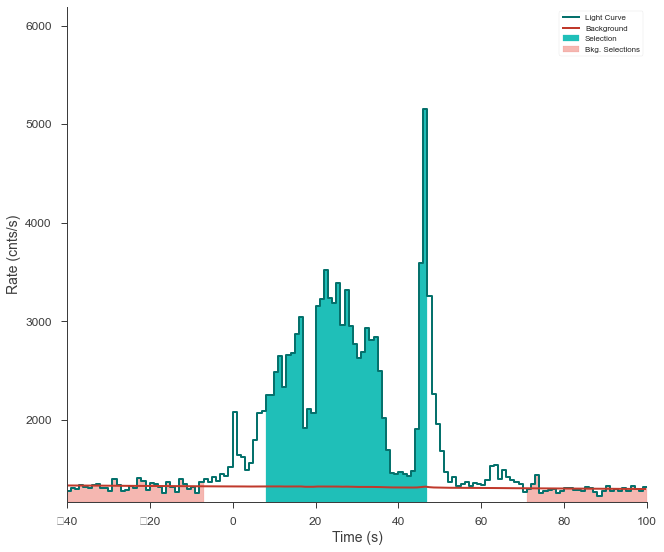

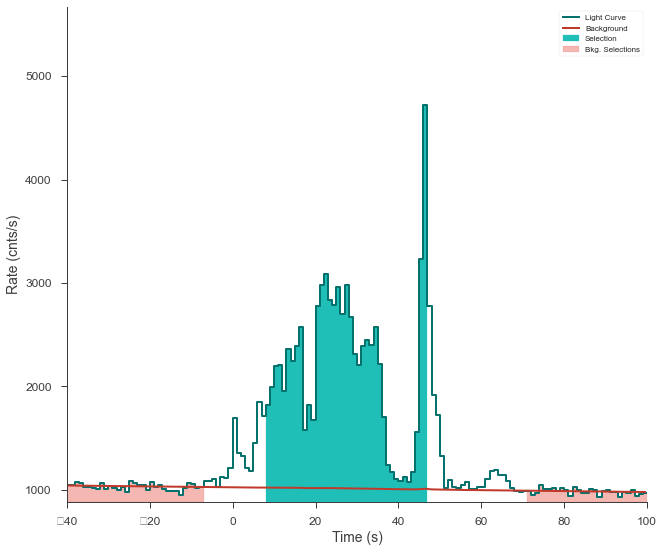

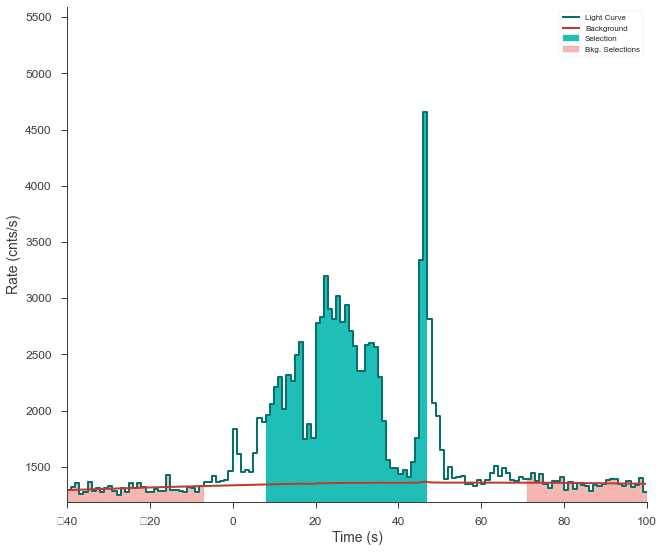

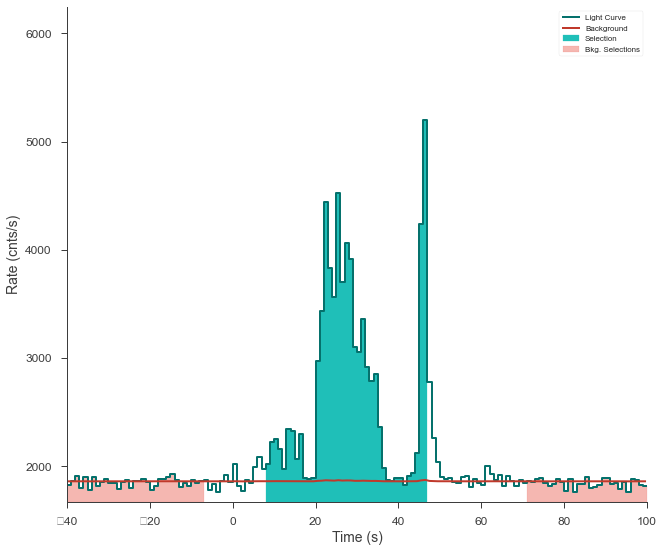

In [31]:
# Now we need to generate a DataList containing the spectral information from the GRB
# Using same calls for light-curve generation

fluence_plugins = []
time_series = {}
figures = []
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    figures.append(ts_tte.view_lightcurve(-40, 100))

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)


dl = DataList(*fluence_plugins)

[INFO    ] sampler set to ultranest
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+04  -10053.00 [-10053.0053..-10053.0053]*| it/evals=21960/22833 eff=97.8915% N=400 0   0   0   
[ultranest] Likelihood function evaluations: 22864
[ultranest]   logZ = -1.01e+04 +- 0.2792
[ultranest] Effective samples strategy satisfied (ESS = 1252.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.70, need <0.5)
[ultranest]   logZ error budget: single: 0.36 bs:0.28 tail:0.03 total:0.28 required:<0.50
[ultranest] done iterating.
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
GRB150118409.spectrum.main.EBH_energy.K,(3.888 +/- 0.015) x 10^-31,1 / (cm2 keV s)



Values of -log(posterior) at the minimum:



,-log(posterior)
b0,-2689.560584
n1,-2639.317037
n2,-2978.197098
n5,-1745.929436
total,-10053.004154



Values of statistical measures:



,statistical measures
AIC,20108.016712
BIC,20112.177920
DIC,20108.007226
PDIC,0.998799
log(Z),-4388.350561


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

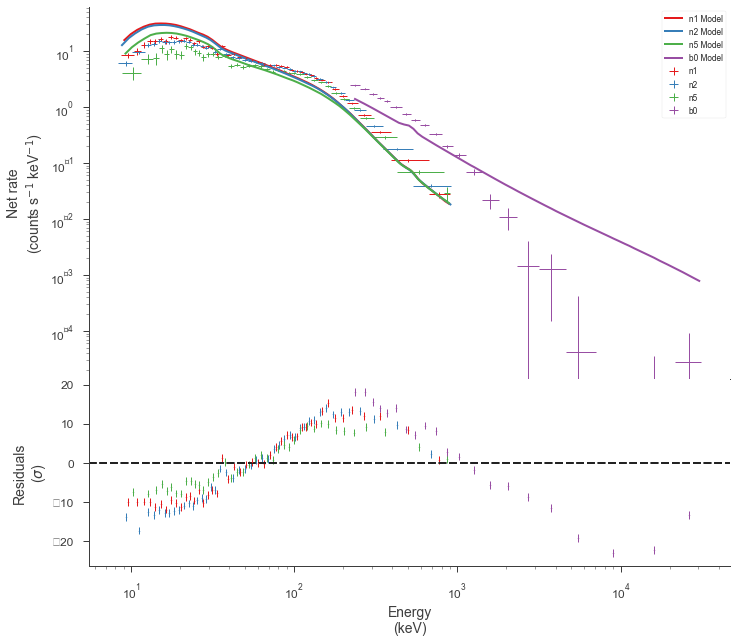

In [127]:
# Instantiating analysis as bayes -- could try JointLikelihood but there are a lot of parameters here
bayes = BayesianAnalysis(model, DataList(*fluence_plugins))

# Choose sampler
bayes.set_sampler("ultranest", share_spectrum=True)

# Run sampler
bayes.sampler.setup(min_num_live_points=400)#n_live_points=400
bayes.sample()
#bayes.restore_median_fit()

fig = display_spectrum_model_counts(bayes, min_rate=20)

Let's now repeat the process for all the GRBs which we've validated as candidates.

In [53]:
# Helper functions
gbm_catalog = FermiGBMBurstCatalog()

def generate_lightcurves(GRBnumber, show_figs = True):
    
    # Query
    gbm_catalog.query_sources("GRB"+GRBnumber)

    grb_info = gbm_catalog.get_detector_information()["GRB"+GRBnumber]

    gbm_detectors = grb_info["detectors"]
    print(gbm_detectors)
    source_interval = grb_info["source"]["fluence"]
    background_interval = grb_info["background"]["full"]
    #best_fit_model = grb_info["best fit model"]["fluence"]
    #model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB150118409"]
    
    # Download data
    dload = download_GBM_trigger_data("bn"+GRBnumber, detectors=gbm_detectors)
    
    fluence_plugins = []
    time_series = {}
    figures = []
    for det in gbm_detectors:

        ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
            det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
        )

        ts_cspec.set_background_interval(*background_interval.split(","))
        ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

        ts_tte = TimeSeriesBuilder.from_gbm_tte(
            det,
            tte_file=dload[det]["tte"],
            rsp_file=dload[det]["rsp"],
            restore_background=f"{det}_bkg.h5",
        )

        time_series[det] = ts_tte

        ts_tte.set_active_time_interval(source_interval)

        figures.append(ts_tte.view_lightcurve(-40, 100))

        fluence_plugin = ts_tte.to_spectrumlike()

        if det.startswith("b"):

            fluence_plugin.set_active_measurements("250-30000")

        else:

            fluence_plugin.set_active_measurements("9-900")

        fluence_plugin.rebin_on_background(1.0)

        fluence_plugins.append(fluence_plugin)
        
    dl = DataList(*fluence_plugins)
        
    if show_figs is True:
        for fig in figures:
            fig.show()

    return dl, grb_info, figures

# Helper fcn for function below
def get_curves(fig):
    data = fig.get_axes()[0].get_lines()[0].get_xydata()
    x = data[:,0]
    curve = data[:,1]
    #background = data[:,2]
    return x, curve#, background

def get_lifetime(figures):
    maxima = []
    for fig in figures:
        x, curve = get_curves(fig)
        print(max(curve))
        print(np.where(curve == max(curve)))
        maxima.append( x[np.where(curve == max(curve))] )
    return np.mean(maxima)
    
# So the peak is at 46s so we can argue that the BH has a remaining lifetime of 46s at t=0
# Time follows linearly such that tau = 46 - t
    
def create_model(GRBnumber, grb_info, lifetime):
    # Instantiate energy EBH model
    spectrum = EBH_energy()

    # Instantiate pointsource
    src = PointSource("GRB"+GRBnumber, ra=grb_info['ra'], dec=grb_info['dec'], spectral_shape=spectrum)

    # Instantiate model
    model = Model(src)

    # Time-dependence
    time = IndependentVariable("time", 1.0, u.s)
    time_dep = Line()
    
    model.add_independent_variable(time)

    # Link time parameters
    model.link(spectrum.time, time, time_dep)

    # Let's define some priors
    grb = getattr(model, 'GRB'+GRBnumber)
    grb.spectrum.main.EBH_energy.time.Line.a = -1.
    grb.spectrum.main.EBH_energy.time.Line.a.free = False
    grb.spectrum.main.EBH_energy.time.Line.b = lifetime
    grb.spectrum.main.EBH_energy.time.Line.b.free = False

    grb.spectrum.main.EBH_energy.K.prior = Uniform_prior(lower_bound=1e-50, upper_bound=1e3)
    

    # This is the completed model
    model.display(complete=True)
    
    return model

def run_fit(model, dl):
    bayes = BayesianAnalysis(model, dl)

    # Choose sampler
    bayes.set_sampler("ultranest", share_spectrum=True)

    # Run sampler
    bayes.sampler.setup(min_num_live_points=400)#n_live_points=400
    bayes.sample()
    #bayes.restore_median_fit()

    fig = display_spectrum_model_counts(bayes, min_rate=20)
    
    return fig, bayes.results

In [56]:
candidates = ['091031500', '140206275', '150118409', '150902733', '160821857', '180718763', '190731943']

def run_pipeline(candidate):
    dl, grb_info, figures = generate_lightcurves(candidate)
    lifetime = get_lifetime(figures)
    model = create_model(candidate, grb_info, lifetime) 
    fig,result = run_fit(model, dl)
    return fig, result, model

['n6' 'n9' 'b1']
[INFO    ] file glg_cspec_n6_bn091031500_v00.pha is already downloaded!
[INFO    ] file glg_cspec_n6_bn091031500_v01.rsp is already downloaded!
[INFO    ] file glg_tte_n6_bn091031500_v00.fit is already downloaded!
[INFO    ] file glg_cspec_n9_bn091031500_v00.pha is already downloaded!
[INFO    ] file glg_cspec_n9_bn091031500_v01.rsp is already downloaded!
[INFO    ] file glg_tte_n9_bn091031500_v00.fit is already downloaded!
[INFO    ] file glg_cspec_b1_bn091031500_v00.pha is already downloaded!
[INFO    ] file glg_cspec_b1_bn091031500_v01.rsp is already downloaded!
[INFO    ] file glg_tte_b1_bn091031500_v00.fit is already downloaded!


Loading PHAII Spectra:   0%|          | 0/2391 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO    ] Auto-determined polynomial order: 0


Fitting GBM_NAI_06 background:   0%|          | 0/128 [00:00<?, ?it/s]

[INFO    ] None 0-order polynomial fit with the bayes method
[INFO    ] Saved fitted background to n6_bkg.h5
[INFO    ] Saved background to n6_bkg.h5
[INFO    ] Successfully restored fit from n6_bkg.h5
[INFO    ] Interval set to 1.408-35.329 for n6
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: gaussian
[INFO    ] Range 9-900 translates to channels 3-123
[INFO    ] Now using 121 bins


Loading PHAII Spectra:   0%|          | 0/2391 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO    ] Auto-determined polynomial order: 3


Fitting GBM_NAI_09 background:   0%|          | 0/128 [00:00<?, ?it/s]

[INFO    ] None 3-order polynomial fit with the bayes method
[INFO    ] Saved fitted background to n9_bkg.h5
[INFO    ] Saved background to n9_bkg.h5
[INFO    ] Successfully restored fit from n9_bkg.h5
[INFO    ] Interval set to 1.408-35.329 for n9
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: gaussian
[INFO    ] Range 9-900 translates to channels 5-123
[INFO    ] Now using 119 bins


Loading PHAII Spectra:   0%|          | 0/2391 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO    ] Auto-determined polynomial order: 0


Fitting GBM_BGO_01 background:   0%|          | 0/128 [00:00<?, ?it/s]

[INFO    ] None 0-order polynomial fit with the bayes method
[INFO    ] Saved fitted background to b1_bkg.h5
[INFO    ] Saved background to b1_bkg.h5
[INFO    ] Successfully restored fit from b1_bkg.h5
[INFO    ] Interval set to 1.408-35.329 for b1
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: gaussian
[INFO    ] Range 250-30000 translates to channels 4-119
[INFO    ] Now using 116 bins
1727.3462701967026
(array([47]),)
2001.4099245027608
(array([48]),)
2829.6342808381837
(array([47]),)


Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (1):
--------------------

                                        value min_value max_value  \
GRB091031500.spectrum.main.EBH_energy.K   1.0       0.0    1000.0   

                                                   unit  
GRB091031500.spectrum.main.EBH_energy.K  keV-1 s-1 cm-2  

Fixed parameters (4):
---------------------

                              value min_value max_value unit
GRB091031500.position.ra       71.7       0.0     360.0  deg
GRB091031500.position.dec     -57.5     -90.0      90.0  deg
GRB091031500...a               -1.0      None      None    s
GRB091031500...b           7.333333      None      None     

Properties (0):
--------------------

(none)


Linked parameters (1):
----------------------

              GRB091031500.spectrum.main.EBH_energy.time
current value                                   6.333333
function                                            Line
linked to                                           time
unit                                                   s


Independent variables:
----------------------

              time
current value  1.0
unit             s


Linked functions (0):
----------------------

(none)

[INFO    ] sampler set to ultranest
[ultranest] Sampling 400 live points from prior ...


KeyboardInterrupt: 


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 miss

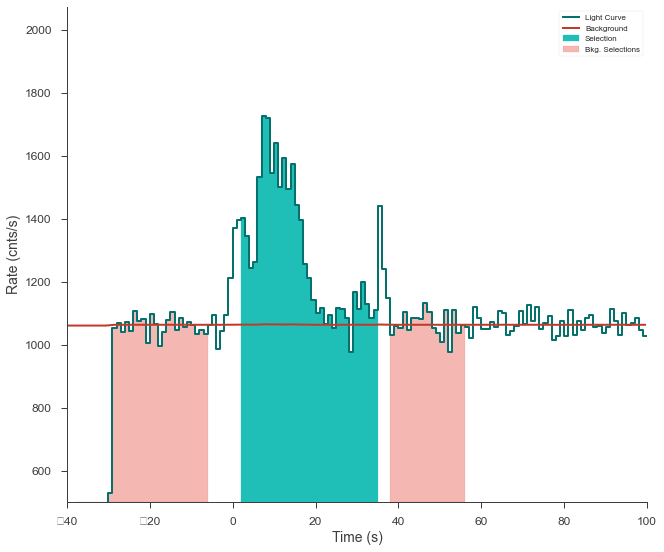


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.



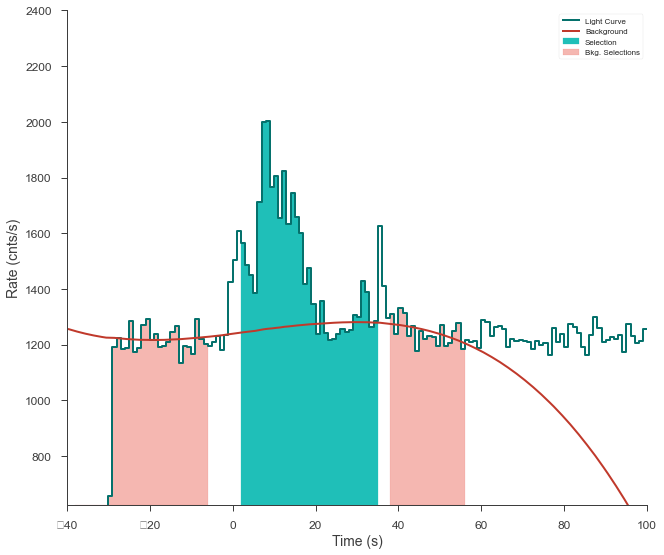


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.



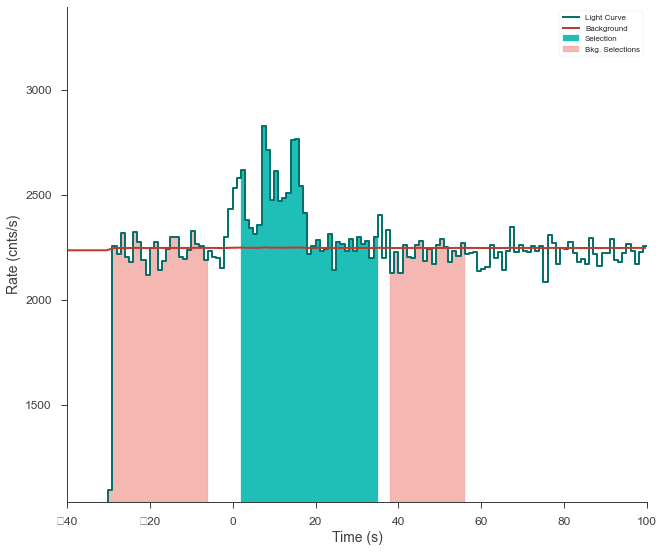

In [59]:
i=0
fig, result, model = run_pipeline(candidates[i])
print(result)
fig

In [118]:
i=1
fig, result, model = run_pipeline(candidates[i])
print(result)
fig

['n0' 'n1' 'n3' 'b0']
[INFO    ] file glg_cspec_n0_bn140206275_v00.pha is already downloaded!
[INFO    ] file glg_cspec_n0_bn140206275_v02.rsp2 is already downloaded!
[INFO    ] file glg_tte_n0_bn140206275_v00.fit is already downloaded!
[INFO    ] file glg_cspec_n1_bn140206275_v00.pha is already downloaded!
[INFO    ] file glg_cspec_n1_bn140206275_v02.rsp2 is already downloaded!
[INFO    ] file glg_tte_n1_bn140206275_v00.fit is already downloaded!
[INFO    ] file glg_cspec_n3_bn140206275_v00.pha is already downloaded!
[INFO    ] file glg_cspec_n3_bn140206275_v02.rsp2 is already downloaded!
[INFO    ] file glg_tte_n3_bn140206275_v00.fit is already downloaded!
[INFO    ] file glg_cspec_b0_bn140206275_v00.pha is already downloaded!
[INFO    ] file glg_cspec_b0_bn140206275_v02.rsp2 is already downloaded!
[INFO    ] file glg_tte_b0_bn140206275_v00.fit is already downloaded!


Loading PHAII Spectra:   0%|          | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO    ] Auto-determined polynomial order: 1


Fitting GBM_NAI_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

[INFO    ] None 1-order polynomial fit with the bayes method
[INFO    ] Saved fitted background to n0_bkg.h5
[INFO    ] Saved background to n0_bkg.h5


TypeError: buffer is too small for requested array

['n0' 'n1' 'n3' 'b0']



WARNING RuntimeWarning: invalid value encountered in true_divide



Loading PHAII Spectra:   0%|          | 0/2394 [00:00<?, ?it/s]


WARNING RuntimeWarning: invalid value encountered in true_divide



Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO    ] Auto-determined polynomial order: 1


Fitting GBM_NAI_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

[INFO    ] None 1-order polynomial fit with the bayes method
[INFO    ] Saved fitted background to n0_bkg.h5
[INFO    ] Saved background to n0_bkg.h5
[INFO    ] Successfully restored fit from n0_bkg.h5
[INFO    ] Interval set to 3.84-17.408 for n0
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: gaussian
[INFO    ] Range 9-900 translates to channels 4-124
[INFO    ] Now using 121 bins



WARNING RuntimeWarning: invalid value encountered in true_divide



Loading PHAII Spectra:   0%|          | 0/2394 [00:00<?, ?it/s]


WARNING RuntimeWarning: invalid value encountered in true_divide



Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO    ] Auto-determined polynomial order: 1


Fitting GBM_NAI_01 background:   0%|          | 0/128 [00:00<?, ?it/s]

[INFO    ] None 1-order polynomial fit with the bayes method
[INFO    ] Saved fitted background to n1_bkg.h5
[INFO    ] Saved background to n1_bkg.h5
[INFO    ] Successfully restored fit from n1_bkg.h5
[INFO    ] Interval set to 3.84-17.408 for n1
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: gaussian
[INFO    ] Range 9-900 translates to channels 5-124
[INFO    ] Now using 120 bins



WARNING RuntimeWarning: invalid value encountered in true_divide



Loading PHAII Spectra:   0%|          | 0/2394 [00:00<?, ?it/s]


WARNING RuntimeWarning: invalid value encountered in true_divide



Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO    ] Auto-determined polynomial order: 1


Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

[INFO    ] None 1-order polynomial fit with the bayes method
[INFO    ] Saved fitted background to n3_bkg.h5
[INFO    ] Saved background to n3_bkg.h5
[INFO    ] Successfully restored fit from n3_bkg.h5
[INFO    ] Interval set to 3.84-17.408 for n3
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: gaussian
[INFO    ] Range 9-900 translates to channels 5-123
[INFO    ] Now using 119 bins



WARNING RuntimeWarning: invalid value encountered in true_divide



Loading PHAII Spectra:   0%|          | 0/2394 [00:00<?, ?it/s]


WARNING RuntimeWarning: invalid value encountered in true_divide



Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO    ] Auto-determined polynomial order: 1


Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

[INFO    ] None 1-order polynomial fit with the bayes method
[INFO    ] Saved fitted background to b0_bkg.h5
[INFO    ] Saved background to b0_bkg.h5
[INFO    ] Successfully restored fit from b0_bkg.h5
[INFO    ] Interval set to 3.84-17.408 for b0
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: gaussian
[INFO    ] Range 250-30000 translates to channels 1-119
[INFO    ] Now using 119 bins
6695.115668720566
(array([49]),)
6292.328830417178
(array([49]),)
7229.51502045706
(array([49]),)
5452.742560532626
(array([49]),)


Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (1):
--------------------

                                        value min_value max_value  \
GRB150902733.spectrum.main.EBH_energy.K   1.0       0.0    1000.0   

                                                   unit  
GRB150902733.spectrum.main.EBH_energy.K  keV-1 s-1 cm-2  

Fixed parameters (4):
---------------------

                             value min_value max_value unit
GRB150902733.position.ra   214.926       0.0     360.0  deg
GRB150902733.position.dec  -69.361     -90.0      90.0  deg
GRB150902733...a              -1.0      None      None    s
GRB150902733...b               9.0      None      None     

Properties (0):
--------------------

(none)


Linked parameters (1):
----------------------

              GRB150902733.spectrum.main.EBH_energy.time
current value                                        8.0
function                                            Line
linked to                                           time
unit                                                   s


Independent variables:
----------------------

              time
current value  1.0
unit             s


Linked functions (0):
----------------------

(none)

[INFO    ] sampler set to ultranest
[ultranest] Sampling 400 live points from prior ...


KeyboardInterrupt: 


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 miss

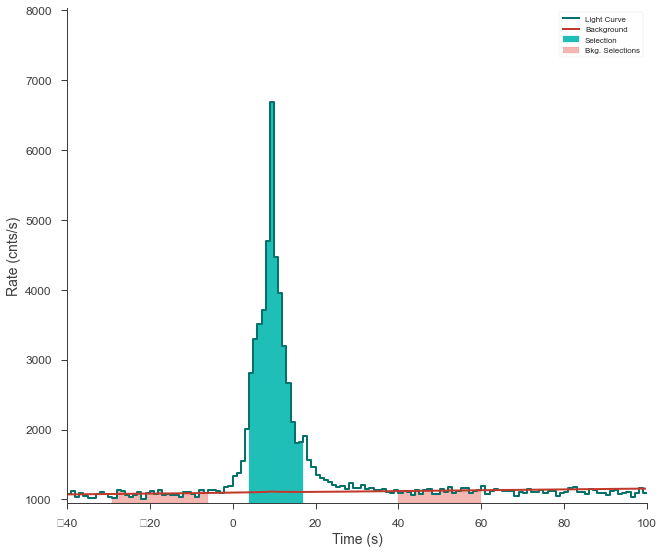


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.



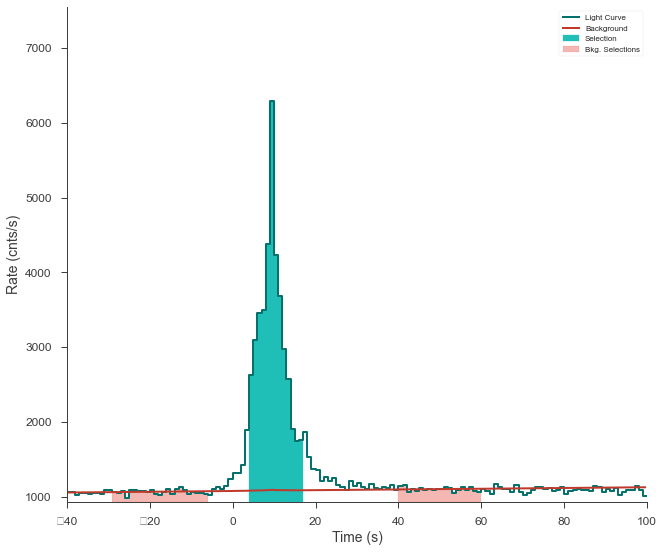


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.



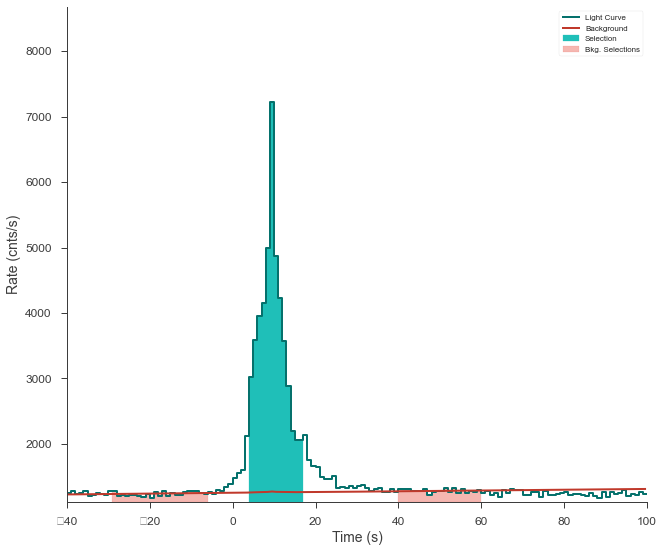


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.


WARNING RuntimeWarning: Glyph 8722 missing from current font.



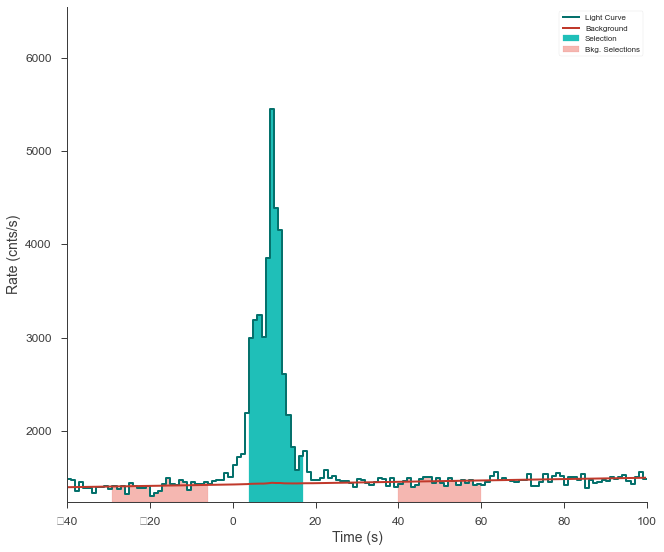

In [60]:
i=3
fig, result, model = run_pipeline(candidates[i])
print(result)
fig

['n6' 'n7' 'n9' 'b1']
[INFO    ] file glg_cspec_n6_bn160821857_v00.pha is already downloaded!
[INFO    ] file glg_cspec_n6_bn160821857_v01.rsp2 is already downloaded!
[INFO    ] file glg_tte_n6_bn160821857_v00.fit is already downloaded!
[INFO    ] file glg_cspec_n7_bn160821857_v00.pha is already downloaded!
[INFO    ] file glg_cspec_n7_bn160821857_v01.rsp2 is already downloaded!
[INFO    ] file glg_tte_n7_bn160821857_v00.fit is already downloaded!
[INFO    ] file glg_cspec_n9_bn160821857_v00.pha is already downloaded!
[INFO    ] file glg_cspec_n9_bn160821857_v01.rsp2 is already downloaded!
[INFO    ] file glg_tte_n9_bn160821857_v00.fit is already downloaded!
[INFO    ] file glg_cspec_b1_bn160821857_v00.pha is already downloaded!
[INFO    ] file glg_cspec_b1_bn160821857_v01.rsp2 is already downloaded!
[INFO    ] file glg_tte_b1_bn160821857_v00.fit is already downloaded!


Loading PHAII Spectra:   0%|          | 0/1935 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO    ] Auto-determined polynomial order: 1


Fitting GBM_NAI_06 background:   0%|          | 0/128 [00:00<?, ?it/s]

[INFO    ] None 1-order polynomial fit with the bayes method
[INFO    ] Saved fitted background to n6_bkg.h5
[INFO    ] Saved background to n6_bkg.h5
[INFO    ] Successfully restored fit from n6_bkg.h5
[INFO    ] Interval set to 118.53-161.539 for n6
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: gaussian
[INFO    ] Range 9-900 translates to channels 3-123
[INFO    ] Now using 121 bins


Loading PHAII Spectra:   0%|          | 0/1935 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO    ] Auto-determined polynomial order: 0


Fitting GBM_NAI_07 background:   0%|          | 0/128 [00:00<?, ?it/s]

[INFO    ] None 0-order polynomial fit with the bayes method
[INFO    ] Saved fitted background to n7_bkg.h5
[INFO    ] Saved background to n7_bkg.h5
[INFO    ] Successfully restored fit from n7_bkg.h5
[INFO    ] Interval set to 118.53-161.539 for n7
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: gaussian
[INFO    ] Range 9-900 translates to channels 4-122
[INFO    ] Now using 119 bins


Loading PHAII Spectra:   0%|          | 0/1935 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO    ] Auto-determined polynomial order: 1


Fitting GBM_NAI_09 background:   0%|          | 0/128 [00:00<?, ?it/s]

[INFO    ] None 1-order polynomial fit with the bayes method
[INFO    ] Saved fitted background to n9_bkg.h5
[INFO    ] Saved background to n9_bkg.h5
[INFO    ] Successfully restored fit from n9_bkg.h5
[INFO    ] Interval set to 118.53-161.539 for n9
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: gaussian
[INFO    ] Range 9-900 translates to channels 5-123
[INFO    ] Now using 119 bins


Loading PHAII Spectra:   0%|          | 0/1935 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO    ] Auto-determined polynomial order: 0


Fitting GBM_BGO_01 background:   0%|          | 0/128 [00:00<?, ?it/s]

[INFO    ] None 0-order polynomial fit with the bayes method
[INFO    ] Saved fitted background to b1_bkg.h5
[INFO    ] Saved background to b1_bkg.h5
[INFO    ] Successfully restored fit from b1_bkg.h5
[INFO    ] Interval set to 118.53-161.539 for b1
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: gaussian
[INFO    ] Range 250-30000 translates to channels 4-119
[INFO    ] Now using 116 bins
1349.914752783071
(array([61]),)
1361.501122711685
(array([61]),)
1492.7050061794778
(array([61]),)
2159.9943713501725
(array([60]),)


Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (1):
--------------------

                                        value min_value max_value  \
GRB190731943.spectrum.main.EBH_energy.K   1.0       0.0    1000.0   

                                                   unit  
GRB190731943.spectrum.main.EBH_energy.K  keV-1 s-1 cm-2  

Fixed parameters (4):
---------------------

                             value min_value max_value unit
GRB190731943.position.ra   171.248       0.0     360.0  deg
GRB190731943.position.dec   42.343     -90.0      90.0  deg
GRB190731943...a              -1.0      None      None    s
GRB190731943...b             20.75      None      None     

Properties (0):
--------------------

(none)


Linked parameters (1):
----------------------

              GRB190731943.spectrum.main.EBH_energy.time
current value                                      19.75
function                                            Line
linked to                                           time
unit                                                   s


Independent variables:
----------------------

              time
current value  1.0
unit             s


Linked functions (0):
----------------------

(none)

[INFO    ] sampler set to ultranest
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+04  -37649.45 [-37649.4554..-37649.4554]*| it/evals=34120/35213 eff=98.0094% N=400 0   0   0  
[ultranest] Likelihood function evaluations: 35222
[ultranest]   logZ = -3.773e+04 +- 0.294
[ultranest] Effective samples strategy satisfied (ESS = 1236.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.73, need <0.5)
[ultranest]   logZ error budget: single: 0.45 bs:0.29 tail:0.04 total:0.30 required:<0.50
[ultranest] done iterating.
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
GRB190731943.spectrum.main.EBH_energy.K,(9.066 +/- 0.013) x 10^-31,1 / (cm2 keV s)



Values of -log(posterior) at the minimum:



,-log(posterior)
b1,-7252.218474
n6,-13432.395031
n7,-10043.081600
n9,-6921.759222
total,-37649.454327



Values of statistical measures:



,statistical measures
AIC,75300.917110
BIC,75305.071968
DIC,75300.819205
PDIC,0.955266
log(Z),-16386.626139


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


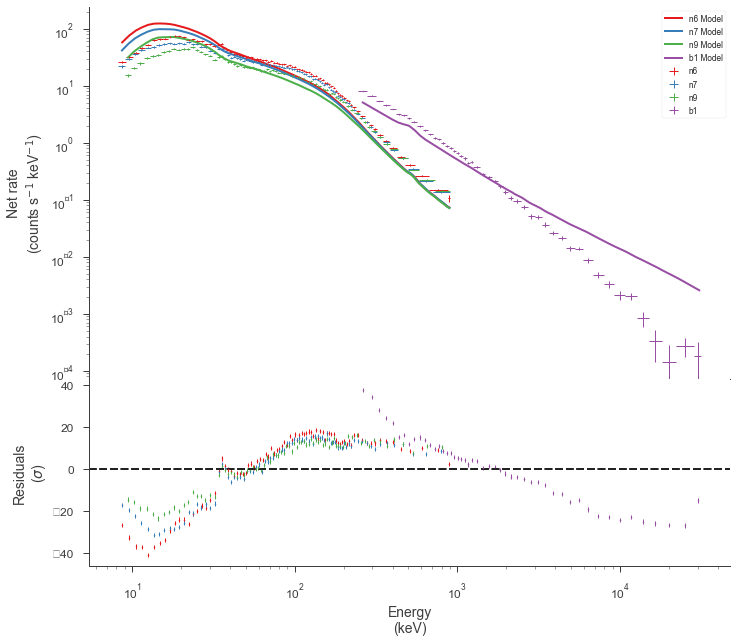

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


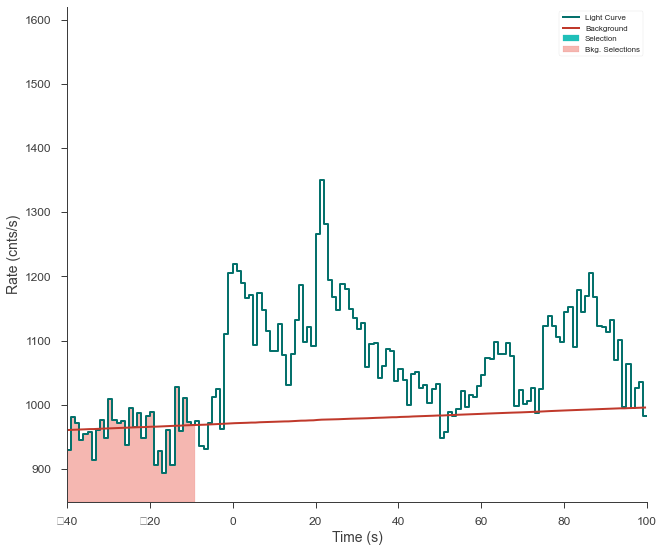

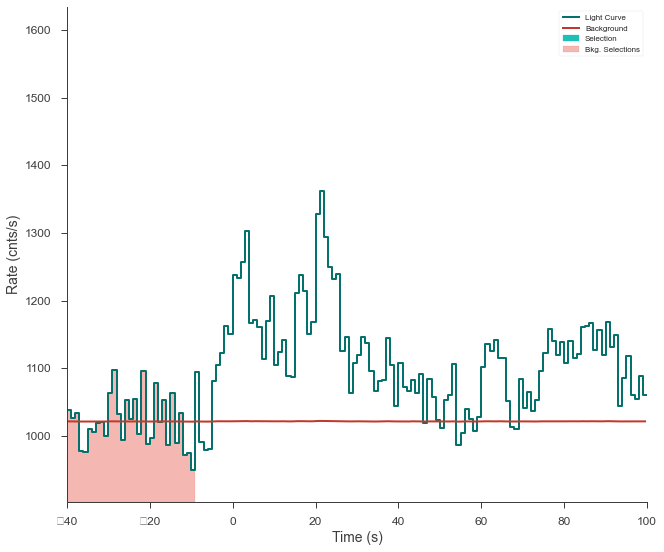

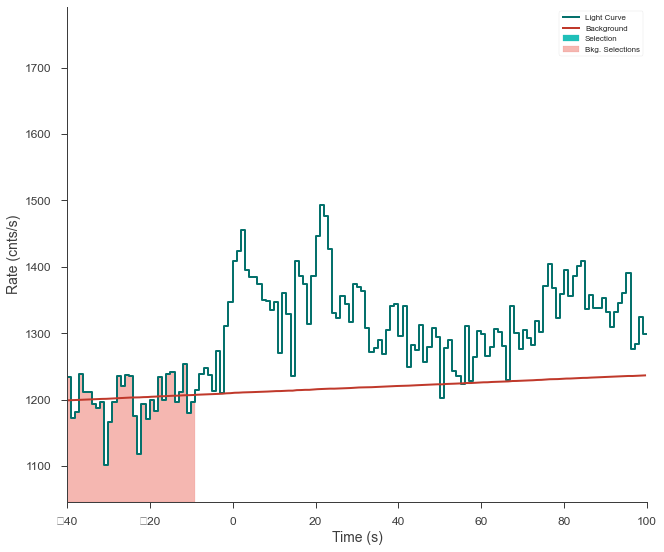

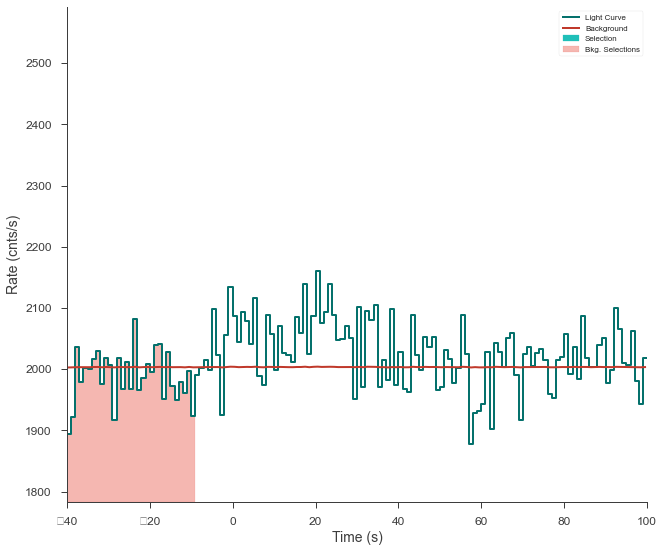

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


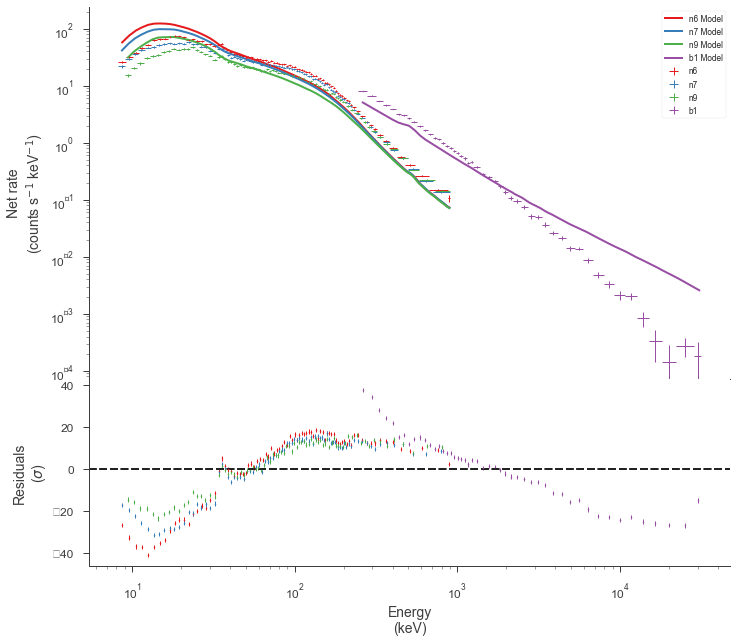

In [120]:
i=4
fig, result, model = run_pipeline(candidates[i])
print(result)
fig

[]


Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (1):
--------------------

                                        value min_value max_value  \
GRB190731943.spectrum.main.EBH_energy.K   1.0       0.0    1000.0   

                                                   unit  
GRB190731943.spectrum.main.EBH_energy.K  keV-1 s-1 cm-2  

Fixed parameters (4):
---------------------

                            value min_value max_value unit
GRB190731943.position.ra   44.677       0.0     360.0  deg
GRB190731943.position.dec -31.503     -90.0      90.0  deg
GRB190731943...a             -1.0      None      None    s
GRB190731943...b              NaN      None      None     

Properties (0):
--------------------

(none)


Linked parameters (1):
----------------------

              GRB190731943.spectrum.main.EBH_energy.time
current value                                        NaN
function                                            Line
linked to                                           time
unit                                                   s


Independent variables:
----------------------

              time
current value  1.0
unit             s


Linked functions (0):
----------------------

(none)

[INFO    ] sampler set to ultranest
[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=0  
[ultranest] Likelihood function evaluations: 400
[ultranest]   logZ = 5.516e-17 +- 1.178e-16
[ultranest] Effective samples strategy satisfied (ESS = 400.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.00, need <0.5)
[ultranest]   logZ error budget: single: inf bs:0.00 tail:0.69 total:0.69 required:<0.50
[ultranest] done iterating.
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
GRB190731943.spectrum.main.EBH_energy.K,(5.3 -3.4 +3.5) x 10^2,1 / (cm2 keV s)



Values of -log(posterior) at the minimum:



,-log(posterior)
total,0.0



Values of statistical measures:



,statistical measures
AIC,0.000000e+00
BIC,0.000000e+00
DIC,-0.000000e+00
PDIC,0.000000e+00
log(Z),-3.390214e-18


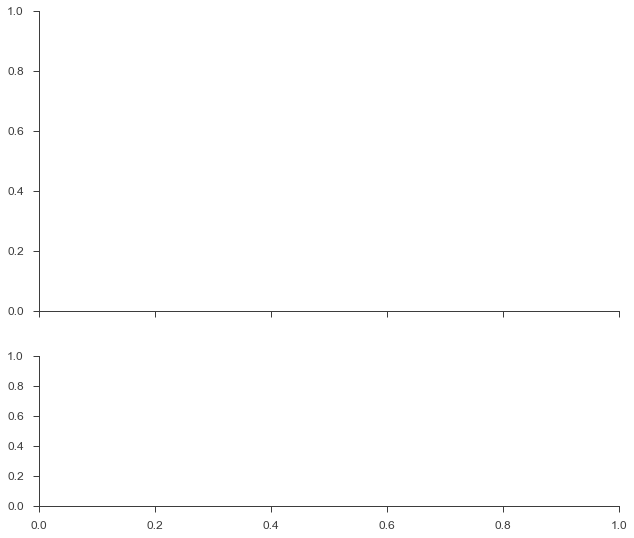

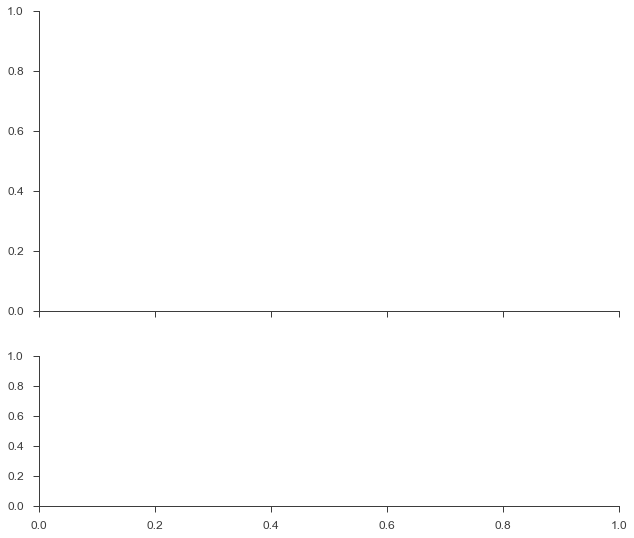

In [122]:
i=5
fig, result, model = run_pipeline(candidates[i])
print(result)
fig

[]


Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (1):
--------------------

                                        value min_value max_value  \
GRB190731943.spectrum.main.EBH_energy.K   1.0       0.0    1000.0   

                                                   unit  
GRB190731943.spectrum.main.EBH_energy.K  keV-1 s-1 cm-2  

Fixed parameters (4):
---------------------

                            value min_value max_value unit
GRB190731943.position.ra   339.94       0.0     360.0  deg
GRB190731943.position.dec  -76.62     -90.0      90.0  deg
GRB190731943...a             -1.0      None      None    s
GRB190731943...b              NaN      None      None     

Properties (0):
--------------------

(none)


Linked parameters (1):
----------------------

              GRB190731943.spectrum.main.EBH_energy.time
current value                                        NaN
function                                            Line
linked to                                           time
unit                                                   s


Independent variables:
----------------------

              time
current value  1.0
unit             s


Linked functions (0):
----------------------

(none)

[INFO    ] sampler set to ultranest
[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=0  
[ultranest] Likelihood function evaluations: 400
[ultranest]   logZ = 5.694e-17 +- 1.025e-16
[ultranest] Effective samples strategy satisfied (ESS = 400.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.00, need <0.5)
[ultranest]   logZ error budget: single: inf bs:0.00 tail:0.69 total:0.69 required:<0.50
[ultranest] done iterating.
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
GRB190731943.spectrum.main.EBH_energy.K,(4.8 -3.4 +3.5) x 10^2,1 / (cm2 keV s)



Values of -log(posterior) at the minimum:



,-log(posterior)
total,0.0



Values of statistical measures:



,statistical measures
AIC,0.000000e+00
BIC,0.000000e+00
DIC,-0.000000e+00
PDIC,0.000000e+00
log(Z),-3.390214e-18


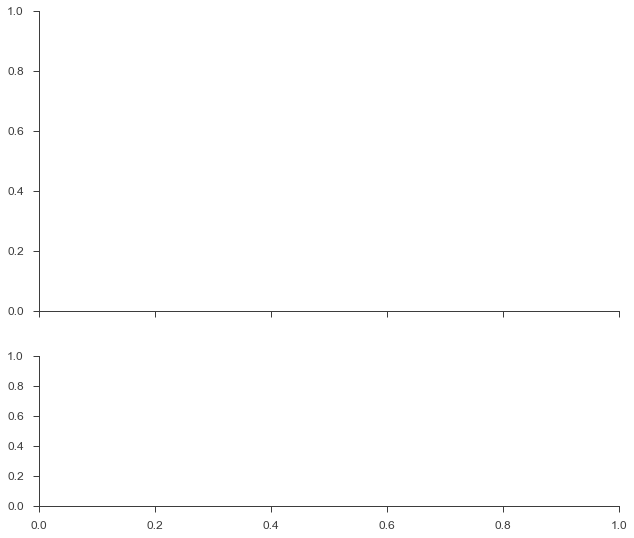

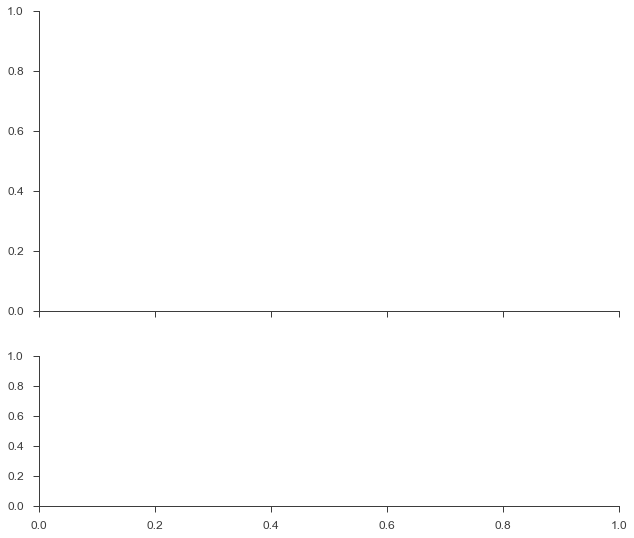

In [123]:
i=6
fig, result, model = run_pipeline(candidates[i])
print(result)
fig

---
## Below is testing -- all calculations WIP

[2.00000000e-29 2.22222222e-15 4.44444444e-15 6.66666667e-15
 8.88888889e-15 1.11111111e-14 1.33333333e-14 1.55555556e-14
 1.77777778e-14 2.00000000e-14]


TypeError: 'CompositeUnit' object is not iterable

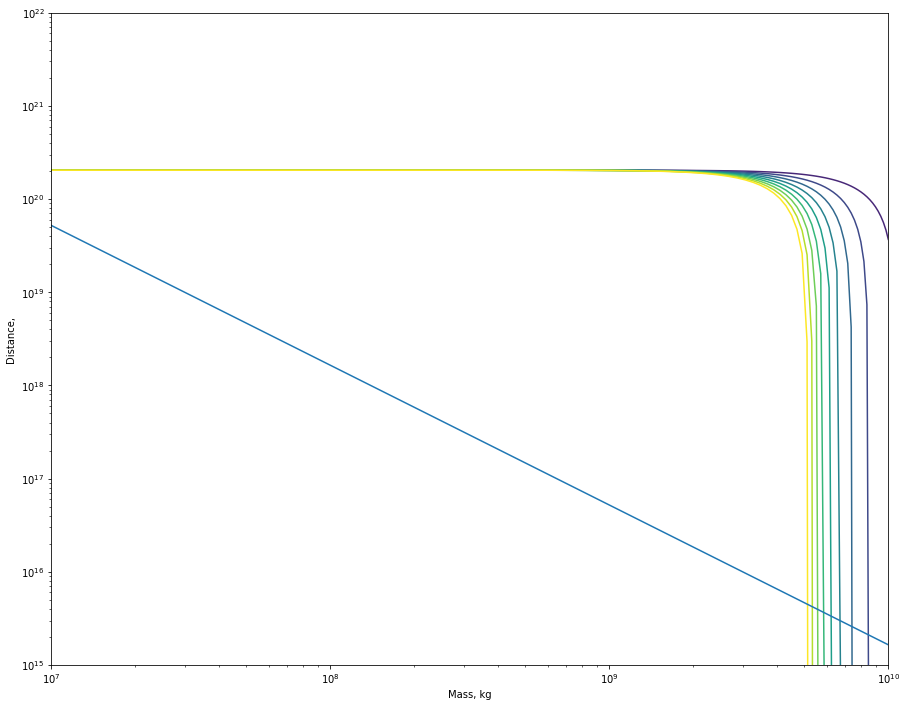

In [15]:
#from matplotlib.ticker import MaxNLocator
#from matplotlib.colors import BoundaryNorm

d = np.linspace(10**15, 10**22) * u.cm

X, Y = np.meshgrid(M,d)

F = func_Md(X, Y).to('g2 / (cm2 s)')

"""
levels = MaxNLocator(nbins=15).tick_values(F.value.min(), F.value.max())
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
"""
levels = np.linspace(2*10**(-29), 2*10**(-14), 10)
print(levels)

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(12)
#plt.pcolormesh(X.value, Y.value, F, cmap=cmap, norm=norm)#, levels=levels)
ax.contour(X.value, Y.value, F, levels=levels)
ax.loglog(M.value, F_d.value)
plt.xlabel('Mass, kg')
plt.ylabel('Distance, ', F[0].unit)
plt.show()

### Temperature and lifetime for PBH decay

Hawking's temperature $T_{BH} = \frac{\hbar c^3}{8 \pi G M k_B}$ and lifetime $\tau(M) \approx \frac{G^2 M^3}{\hbar c^4}$ [eqs 9, 10](https://arxiv.org/pdf/2002.12778.pdf)

where $E_\gamma \approx 4.4T_{BH}$

<!-- 
Black hole temperature as a function of remaining lifetime $T(\tau) \approx 7.8 \times 10^3 (\frac{1s}{\tau}^1/3)$ GeV (in natural units) [eqn 3.1](https://arxiv.org/pdf/1911.04356.pdf)

where $T_{BH} = -5.34 \times 10^{-5} f(M) M_{10}^{-2} / s$ for black hole mass $M = M_{10} \times 10^{10} g$


Emission rate $\frac{dN_\gamma}{dE_\gamma} \approx 9 \times 10^{35} $ 


Flux $\frac{d^2N}{dtdE} \approx \frac{\Gamma}{e^{E/T} -1}$ for greybody factor $\Gamma = \frac{E^2}{M_{BH}^2}$

BH emission rate $\frac{dM_{10}}{dt} = -5.34 \times 10^{-5} f(M) M_{10}^{-2}$ /s where we can allow f(M) ~ 10^-2
-->

In [88]:
#M = 5.1 * 10**14 * u.g
M = [1, 4.25, 10] * u.g * 10**10

T = c.hbar * c.c**3 / (8 * 3.14159 * c.G * M * c.k_B)
print(T.to('K'))

tau = c.G**2 * M**3 / (c.hbar * c.c**4)
print(tau.to('s'))

# checking against paper's values:
#print('T * M / M_o : ', T * M / c.M_sun)
#print('tau / (M/M_o)3 : ', (tau / (M/c.M_sun)**3).to('yr'))

[1.22690171e+16 2.88682755e+15 1.22690171e+15] K
[5.22940737e+00 4.01438725e+02 5.22940737e+03] s


[HAWC burst rate study](https://arxiv.org/pdf/1911.04356.pdf) concludes local burst rate density $\dot{\rho} < 3400 pc^{-3}yr{-1}$

From Stefano's notes: use 400s multiplied by M10
$\rho_{PBH} < 400 \times 3400\frac{s}{pc^3 yr}$



In [112]:
pbh_density = ( 400 * 3400 * u.second / u.year ).to('') / u.pc**3

nearest_pbh = pbh_density**(-1/3)

print('Pbh spacing: ',nearest_pbh)
nearest_pbh

flux_ratio(np.mean(list(J_factors.values()))*unit , DM_density, nearest_pbh)

Pbh spacing:  2.8522550182793966 pc


<Quantity [17.52045884,  8.76022942]>

However, I interpreted this number multiplied against burst rate density as the 'amount of time' that we are looking. This is because the burst rate density limits the amount of these bursts that are possible as a factor of the observation time (assuming that these bursts are constantly going, unlike the hypothesis that they resemble supernovae).

This subsequent calculation assumes that we are looking over the course of one year and that PBH explosions endure throughout the entirety of the year. This is unrealistic as the explosion will not take a full year and the photon flux will vary across several orders of magnitude throughout the duration of the explosion.

In [123]:
pbh_density = 3400 / u.pc**3

nearest_pbh = pbh_density**(-1/3)

print(nearest_pbh)

hawc_mod = flux_ratio(np.mean(list(J_factors.values()))*unit , DM_density, nearest_pbh)

print('Flux ratio %s per year'%( hawc_mod) )

0.06650286584282478 pc
Flux ratio [751.43854344 375.71927172] per year


### Comparison with other sources of DM mass

M31, draco dwarf galaxy, COMA galaxy cluster

LSBGs [link](https://arxiv.org/pdf/1906.06701.pdf)

[Perseus, CCO, M31, dwarfs, virgo, coma](https://arxiv.org/pdf/1410.7766.pdf)

<!--
if we know $\phi_\gamma$, gives us limit on photon flux signal

: Stefano mentioned that they could appear as supernova do -- sparsely -- or just too infrequently to contrast background EBL

try to figure out a way to evaluate expected emission value and std 
-->

useful papers

[PBHs as DM candidates](https://arxiv.org/pdf/2110.02821.pdf)

[Constraints on PBHs](https://arxiv.org/pdf/2002.12778.pdf)

[PBHs from cosmic phase transition: fermi balls](https://arxiv.org/pdf/2106.00111v2.pdf)

[Unidentified objects in LAT's 3 year catalog](https://arxiv.org/pdf/1601.06781.pdf)

